# GP Backtesting
The purpose of this section is to load the GP local volatility surface and perform the Monte-Carlo backtest of the option prices uses the GP local volatility surface. Note that the GP local volatility is generated by running the Matlab code in the "code/GP" folder. See Section "GP Local Volatility Backtests" below for further details of the backtests.

## Help on Importing files

If you run this notebook on google colab you need to upload python scripts on the left panel.
To that end click on the left "Files" (or "Fichiers" in French) and drag and drop :
- python scripts from the "code" folder of github repository.
- csv files or xls files from "data" folder.
- Tensorflow model (files with .data or .index extensions) in the "Results" folder if you want to use the neural network while avoiding the training step.
- csv files in "Results" folder if you want to load Results presented in our paper.


In [1]:
import sys
formerPath = sys.path
sys.path.append('./code/')
sys.path.append('./BS/')

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn as skl
import bootstrapping
import dataSetConstruction
import backtest
import BS
import loadData
import plotTools
import SSVI
import importlib
from Bisect import bisect
from newton import newton
from BSImplVol import bsimpvol

# Load data

In order to reproduce our paper experiments, execute cells from part "Load preformatted data". 

Each source of data produces the following objects : 
- bootstrap manages discounting and dividend.
- dataSet contains the training set.
- dataSetTest contains the testing set.
- $S0$ the spot value of the underlying 

In [3]:
importlib.reload(loadData)

<module 'loadData' from './code/loadData.py'>

In [4]:
pd.options.mode.chained_assignment = 'raise'

#### SPX Data

File required : 
- yieldCurve.dat.
- Option_SPX_18_Mai_2019Feuille2.xlsm

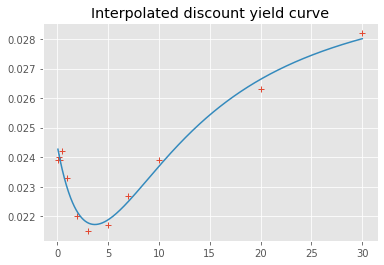

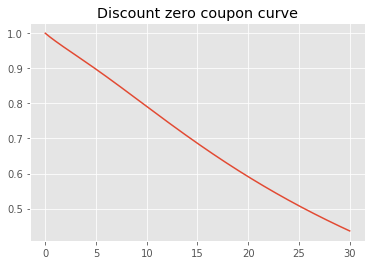

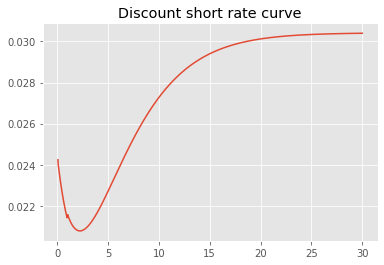

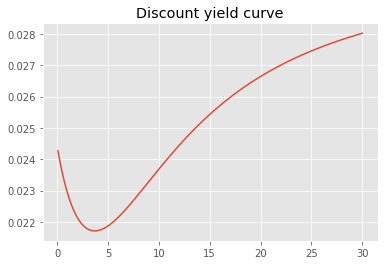

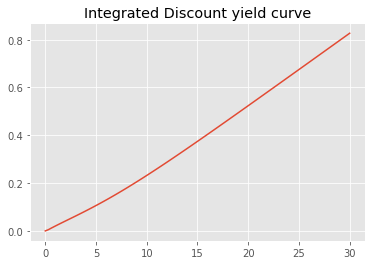

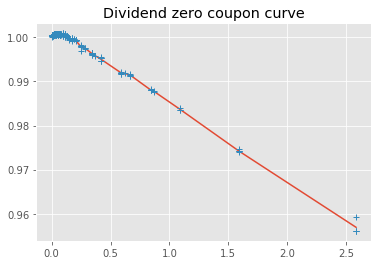

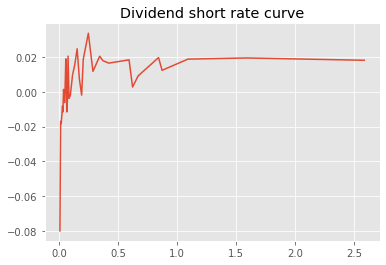

./code/bootstrapping.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / x - 1) / float(t)


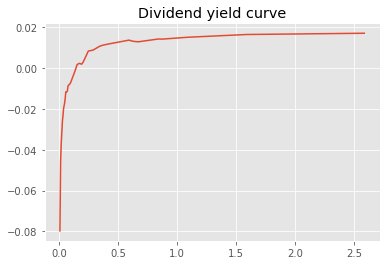

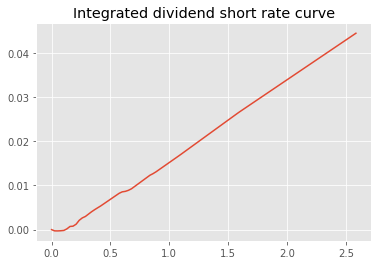

In [5]:
workingFolder = "./data/"
fileName = "Option_SPX_18_Mai_2019Feuille2.xlsm"
asOfDate = "2019-05-18"
trainingSet, testingSet, bootstrap, S0 = loadData.loadCBOTData(workingFolder, fileName, asOfDate)

In [6]:
importlib.reload(bootstrapping)

<module 'bootstrapping' from './code/bootstrapping.py'>

#### Load preformatted data

File required : 
- testingDataSet.csv
- trainingDataSet.csv
- dfCurve.csv

In [10]:
workingFolder = "./data/"
trainingSet, testingSet, bootstrap, S0 = loadData.loadFormattedData(workingFolder)

# Formatting data

### Boostsrapping Rate Curve

We assume a piecewise constant discount short rate $r$ and a piecewise constant dividend short rate $q$.

We estimate the "zero coupon dividend" $D(T) = e^{-\int_{0}^{T} q_s ds}$ by regressing it against maturity :
$$e^{-\int_{0}^{T} q_s ds} = \frac{C(T,K) - P(T,K) + K e^{-\int_{0}^{T} r_s ds}}{S_0}$$


Then we have $\hat{q}_t = - \frac{ \log{D(\overline{T})} - \log{D(\underline{T})} }{ \overline{T} - \underline{T} }$ with $\overline{T}$ the smallest discretized maturity greater than $T$ and $\underline{T}$ the grestest discretized maturity inferior than $T$.

bootstrap object has several members :
- **riskFreeIntegral** corresponds to $I_T = \int_{0}^{T} r_u du$.
- **riskFreeSpline**  corresponds to $r_u$ evaluated on a subgrid. Interpolated as step function from zero coupons
- **divSpreadIntegral** corresponds to $I_T = \int_{0}^{T} q_u du$, can be negative.
- **divSpline**  corresponds to $q_u$ evaluated on a subgrid, can be negative.

These curve should satisfy the call-put parity.

#### Change of variable

Neural network on modified prices with modified strike as input such that discounting and dividend don't intervene in Dupire formula calculation.


- In presence of dividend rate $d$ and risk free rate $r$ Dupire formula is :   $$\sigma^2(T,K) = 2 \frac{ \partial_T P(T,K) + (r-q) K \partial_K P(T,K) + qP(T,K)}{K² \partial_{K}^2 P(T,K)}$$ 
with Strike $K$, Maturity $T$, dividend rate $q$ and risk-free rate $r$, $P$ our pricing function. 
- We apply the following change of variable : $$ w(T,k) = \exp{(\int_{0}^{T} q_t dt)} P(T,K)$$ with $K = k \exp{(\int_{0}^{T} (r_t - q_t) dt)} $.
- Then Dupire equation becomes :  $\sigma^2(T,K) = 2 \frac{ \partial_T w(T,k)}{k² \partial_{k}^2 w(T,k)}$. 
- If we learn the mapping $v$ with a neural network then we obtain quickly by adjoint differentiation $\partial_T w$ and $\partial_{k²}^2 w$ and therefore $\sigma$.
- $k$ corresponds to "ChangedStrike" column.
- $\exp{(\int_{0}^{T} q_t dt)}$ corresponds to "DividendFactor" column.


In [11]:
dataSet = trainingSet #Training set
dataSetTest = testingSet #Testing set
dataSet.head()

Price     Delta        Vega  Delta Strike  Gamma Strike  \
Strike Maturity                                                            
2200.0 0.419      9.95 -0.047968  184.678147      0.094049 -9.963916e-07   
2325.0 0.112      1.65 -0.015858   38.013410      0.027412 -3.969604e-05   
2400.0 0.093      1.60 -0.017779   38.199664      0.029753 -4.470370e-05   
2510.0 0.170      9.15 -0.074660  166.318158      0.128221  5.540400e-05   
2525.0 0.036      0.55 -0.010731   15.378146      0.016613 -5.456899e-05   

                      Theta  ChangedStrike  DividendFactor  Strike  Maturity  \
Strike Maturity                                                                
2200.0 0.419     103.538454    2194.553900        0.994628  2200.0     0.419   
2325.0 0.112      73.268907    2323.142879        1.000111  2325.0     0.112   
2400.0 0.093      88.192154    2398.742294        1.000292  2400.0     0.093   
2510.0 0.170     230.171845    2506.841932        0.999189  2510.0     0.170   
2525.0 0.036      87.679835    2524.212274        1.000312  2525.0     0.036   

                 ImpliedVol     VegaRef  OptionType  logMoneyness  \
Strike Maturity                                                     
2200.0 0.419         0.2586  169.246997        -1.0     -0.264678   
2325.0 0.112         0.2958   15.762704        -1.0     -0.207736   
2400.0 0.093         0.2798   22.362901        -1.0     -0.175713   
2510.0 0.170         0.2289  194.599716        -1.0     -0.131634   
2525.0 0.036         0.2893    6.408137        -1.0     -0.124728   

                 impliedTotalVariance  
Strike Maturity                        
2200.0 0.419                 0.028020  
2325.0 0.112                 0.009800  
2400.0 0.093                 0.007281  
2510.0 0.170                 0.008907  
2525.0 0.036                 0.003013

In [12]:
dataSetTest.head()

Price     Delta        Vega  Delta Strike  Gamma Strike  \
Strike Maturity                                                            
1700.0 0.246      0.80 -0.004171   17.445534      0.009788     -0.000018   
2300.0 0.419     14.30 -0.069169  246.251489      0.132054      0.000036   
2350.0 0.093      1.20 -0.013019   29.227795      0.022052     -0.000041   
       0.112      1.85 -0.018041   42.445051      0.030966     -0.000041   
2400.0 0.419     20.55 -0.099289  323.155078      0.185544      0.000106   

                      Theta  ChangedStrike  DividendFactor  Strike  Maturity  \
Strike Maturity                                                                
1700.0 0.246      15.329284    1697.643924        0.997527  1700.0     0.246   
2300.0 0.419     140.724773    2294.306350        0.994628  2300.0     0.419   
2350.0 0.093      66.591651    2348.768497        1.000292  2350.0     0.093   
       0.112      82.136307    2348.122910        1.000111  2350.0     0.112   
2400.0 0.419     187.583551    2394.058800        0.994628  2400.0     0.419   

                 ImpliedVol     VegaRef  OptionType  logMoneyness  \
Strike Maturity                                                     
1700.0 0.246         0.4147    0.062925        -1.0     -0.521416   
2300.0 0.419         0.2424  261.160274        -1.0     -0.220227   
2350.0 0.093         0.2959   11.271760        -1.0     -0.196766   
       0.112         0.2875   21.589857        -1.0     -0.197041   
2400.0 0.419         0.2264  368.610408        -1.0     -0.177667   

                 impliedTotalVariance  
Strike Maturity                        
1700.0 0.246                 0.042306  
2300.0 0.419                 0.024620  
2350.0 0.093                 0.008143  
       0.112                 0.009257  
2400.0 0.419                 0.021477

In [13]:
dfCurve = dataSetConstruction.savingData(bootstrap, 
                                         dataSet, 
                                         dataSetTest, 
                                         workingFolder)

Saving bootstrapping under dfCurve.csv
Saving training set under trainingDataSet.csv
Saving bootstrapping under testingDataSet.csv


In [14]:
threshold = pd.concat([dataSet, dataSetTest])["Price"].sort_values().iloc[int(0.05 * pd.concat([dataSet, dataSetTest]).shape[0])]
threshold

2.05

In [15]:
dataSet.shape

(135, 15)

In [16]:
dataSetTest.shape

(144, 15)

In [17]:
S0

2859.53

In [18]:
def getCall(df):
    return df[df["OptionType"]==1]
def getPut(df):
    return df[df["OptionType"]==-1]

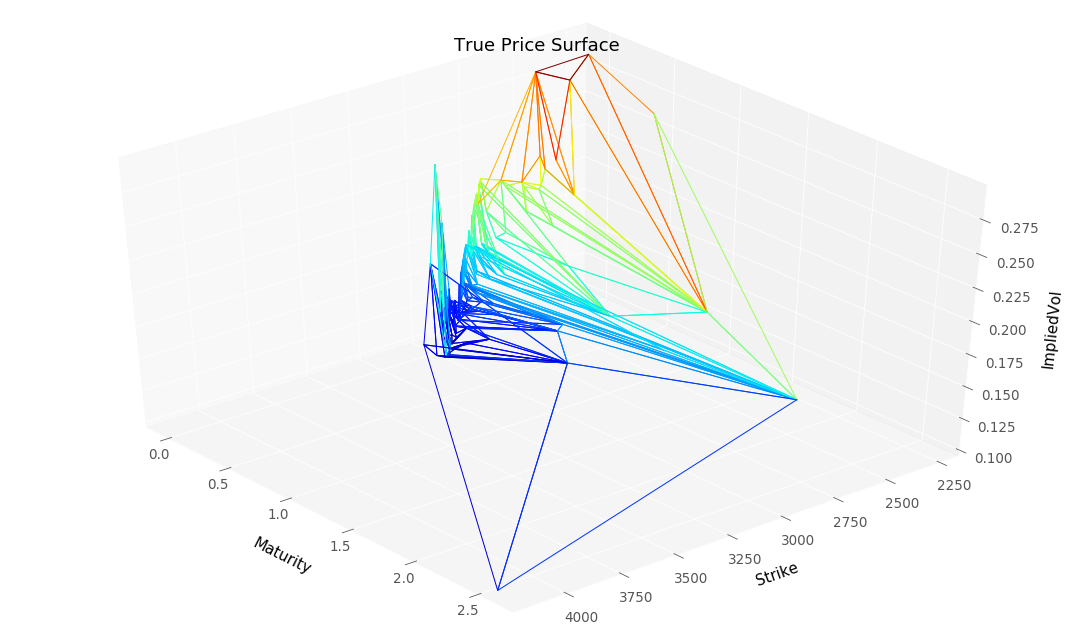

In [19]:
plotTools.plotSerie(getPut(trainingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

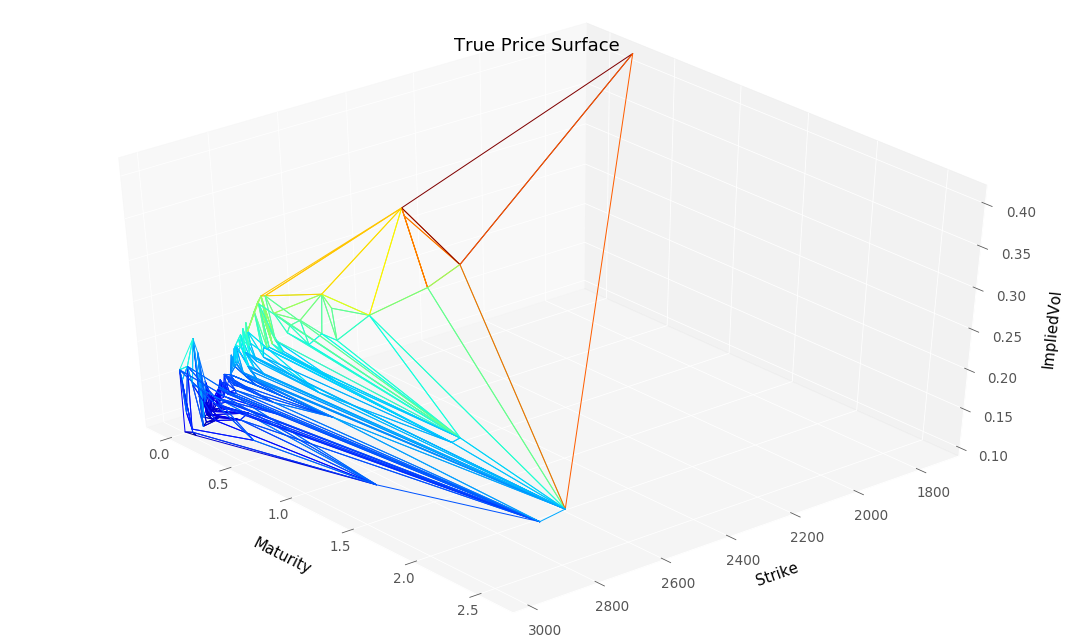

In [20]:
plotTools.plotSerie(getPut(testingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

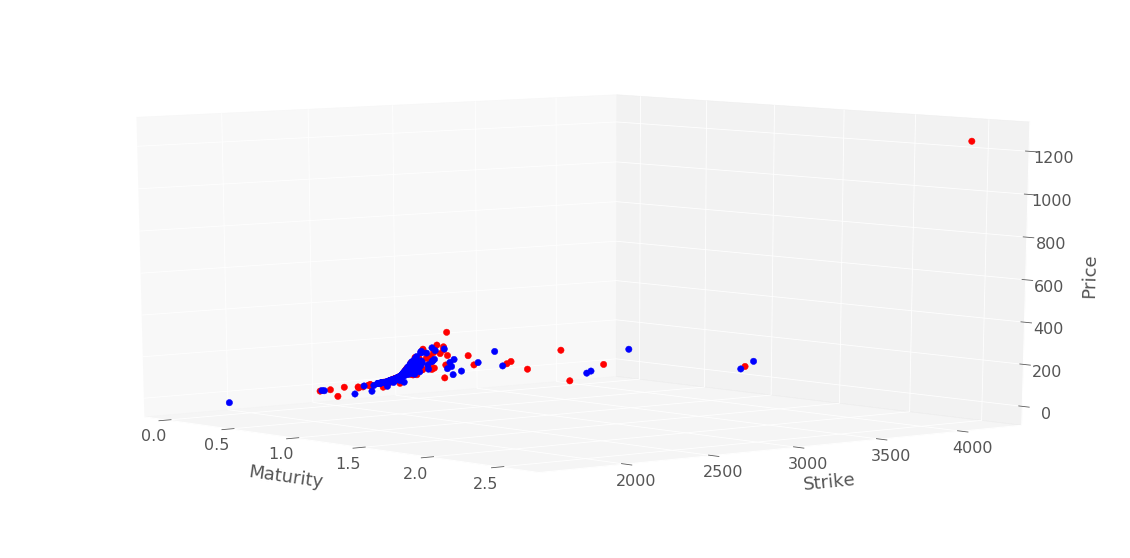

In [21]:
plotTools.plot2Series(getPut(testingSet)["Price"], 
                      getPut(trainingSet)["Price"], 
                      yMin=0,
                      yMax=3*S0, 
                      Title = 'True Price Surface')

## Scaling methods

Use min-max of scaling strike between 0 et 1 for improving stability of neural network training. 



In [22]:
activateScaling = False
transformCustom = dataSetConstruction.transformCustomMinMax if activateScaling else dataSetConstruction.transformCustomId
inverseTransform = dataSetConstruction.inverseTransformMinMax if activateScaling else dataSetConstruction.inverseTransformId
inverseTransformColumn = dataSetConstruction.inverseTransformColumnMinMax if activateScaling else dataSetConstruction.inverseTransformColumnId
inverseTransformColumnGreeks = dataSetConstruction.inverseTransformColumnGreeksMinMax if activateScaling else dataSetConstruction.inverseTransformColumnGreeksId

In [23]:
scaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataSet)
scaledDataSet = transformCustom(dataSet, scaler)
scaledDataSetTest = transformCustom(dataSetTest, scaler)

In [24]:
scaledDataSet.head()

Price     Delta        Vega  Delta Strike  Gamma Strike  \
Strike Maturity                                                            
2200.0 0.419      9.95 -0.047968  184.678147      0.094049 -9.963916e-07   
2325.0 0.112      1.65 -0.015858   38.013410      0.027412 -3.969604e-05   
2400.0 0.093      1.60 -0.017779   38.199664      0.029753 -4.470370e-05   
2510.0 0.170      9.15 -0.074660  166.318158      0.128221  5.540400e-05   
2525.0 0.036      0.55 -0.010731   15.378146      0.016613 -5.456899e-05   

                      Theta  ChangedStrike  DividendFactor  Strike  Maturity  \
Strike Maturity                                                                
2200.0 0.419     103.538454    2194.553900        0.994628  2200.0     0.419   
2325.0 0.112      73.268907    2323.142879        1.000111  2325.0     0.112   
2400.0 0.093      88.192154    2398.742294        1.000292  2400.0     0.093   
2510.0 0.170     230.171845    2506.841932        0.999189  2510.0     0.170   
2525.0 0.036      87.679835    2524.212274        1.000312  2525.0     0.036   

                 ImpliedVol     VegaRef  OptionType  logMoneyness  \
Strike Maturity                                                     
2200.0 0.419         0.2586  169.246997        -1.0     -0.264678   
2325.0 0.112         0.2958   15.762704        -1.0     -0.207736   
2400.0 0.093         0.2798   22.362901        -1.0     -0.175713   
2510.0 0.170         0.2289  194.599716        -1.0     -0.131634   
2525.0 0.036         0.2893    6.408137        -1.0     -0.124728   

                 impliedTotalVariance  
Strike Maturity                        
2200.0 0.419                 0.028020  
2325.0 0.112                 0.009800  
2400.0 0.093                 0.007281  
2510.0 0.170                 0.008907  
2525.0 0.036                 0.003013

In [26]:
#Search strike for ATM option
midS0 = dataSet[dataSet.index.get_level_values("Strike") >= S0].index.get_level_values("Strike").min()

In [27]:
KMin = 0#0.7 * S0[0]
KMax = 2.0 * S0#1.3 * S0[0]

# Load GP Results

This section loads result from the Matlab experiments.
See code/GP folder to access the matlab script.

In [28]:
pathFolder = "./data/"
fileName = "GP_output_Put_Price_testing_set.xlsx"
putTestingGP = pd.read_excel(pathFolder + fileName,
                             header=0,
                             sheet_name = "Sheet1")
putTestingGP["Strike"] = np.exp(+ bootstrap.discountIntegral(putTestingGP["T"])
                                - bootstrap.dividendIntegral(putTestingGP["T"])) * putTestingGP["K"]
putTestingGP["Maturity"] = putTestingGP["T"]
putTestingGP = putTestingGP.set_index(["Strike","Maturity"], drop=False)

putTestingGP = pd.DataFrame(putTestingGP.values, columns = putTestingGP.columns, index = dataSetTest.index)
putTestingGP["Strike"] = dataSetTest["Strike"]
putTestingGP["Maturity"] = dataSetTest["Maturity"]

putTestingGP.head()

K      T  GP_Modified_Put_price  GP_Put_price  \
Strike Maturity                                                            
1700.0 0.246     1697.643924  0.246               1.529623      1.526542   
2300.0 0.419     2294.306350  0.419              13.529379     13.456314   
2350.0 0.093     2348.768497  0.093               0.924816      0.925103   
       0.112     2348.122910  0.112               2.011405      2.011567   
2400.0 0.419     2394.058800  0.419              19.765341     19.658598   

                 Strike  Maturity  
Strike Maturity                    
1700.0 0.246     1700.0     0.246  
2300.0 0.419     2300.0     0.419  
2350.0 0.093     2350.0     0.093  
       0.112     2350.0     0.112  
2400.0 0.419     2400.0     0.419

In [29]:
putTestingGP.tail()

K      T  GP_Modified_Put_price  GP_Put_price  \
Strike Maturity                                                            
3000.0 1.588     2980.007887  1.588             275.267066    268.076154   
3005.0 0.016     3004.417707  0.016             142.432079    142.608428   
3015.0 0.112     3012.591733  0.112             154.114599    154.127043   
3025.0 0.074     3024.282210  0.074             163.303537    163.391511   
       0.170     3021.193962  0.170             165.823160    165.720704   

                 Strike  Maturity  
Strike Maturity                    
3000.0 1.588     3000.0     1.588  
3005.0 0.016     3005.0     0.016  
3015.0 0.112     3015.0     0.112  
3025.0 0.074     3025.0     0.074  
       0.170     3025.0     0.170

In [30]:
dataSet.head()

Price     Delta        Vega  Delta Strike  Gamma Strike  \
Strike Maturity                                                            
2200.0 0.419      9.95 -0.047968  184.678147      0.094049 -9.963916e-07   
2325.0 0.112      1.65 -0.015858   38.013410      0.027412 -3.969604e-05   
2400.0 0.093      1.60 -0.017779   38.199664      0.029753 -4.470370e-05   
2510.0 0.170      9.15 -0.074660  166.318158      0.128221  5.540400e-05   
2525.0 0.036      0.55 -0.010731   15.378146      0.016613 -5.456899e-05   

                      Theta  ChangedStrike  DividendFactor  Strike  Maturity  \
Strike Maturity                                                                
2200.0 0.419     103.538454    2194.553900        0.994628  2200.0     0.419   
2325.0 0.112      73.268907    2323.142879        1.000111  2325.0     0.112   
2400.0 0.093      88.192154    2398.742294        1.000292  2400.0     0.093   
2510.0 0.170     230.171845    2506.841932        0.999189  2510.0     0.170   
2525.0 0.036      87.679835    2524.212274        1.000312  2525.0     0.036   

                 ImpliedVol     VegaRef  OptionType  logMoneyness  \
Strike Maturity                                                     
2200.0 0.419         0.2586  169.246997        -1.0     -0.264678   
2325.0 0.112         0.2958   15.762704        -1.0     -0.207736   
2400.0 0.093         0.2798   22.362901        -1.0     -0.175713   
2510.0 0.170         0.2289  194.599716        -1.0     -0.131634   
2525.0 0.036         0.2893    6.408137        -1.0     -0.124728   

                 impliedTotalVariance  
Strike Maturity                        
2200.0 0.419                 0.028020  
2325.0 0.112                 0.009800  
2400.0 0.093                 0.007281  
2510.0 0.170                 0.008907  
2525.0 0.036                 0.003013

In [31]:
ImpVolPutTesting = BS.vectorizedImpliedVolatilityCalibration(S0, bootstrap, 
                                                             putTestingGP["T"], 
                                                             putTestingGP["Strike"], 
                                                             -1 * np.ones_like(putTestingGP["Strike"]), 
                                                             putTestingGP["GP_Put_price"],
                                                             removeNaN= False)
ImpVolPutTesting = pd.Series(ImpVolPutTesting, index = putTestingGP.set_index(["Strike","Maturity"], drop=False).index).sort_index()

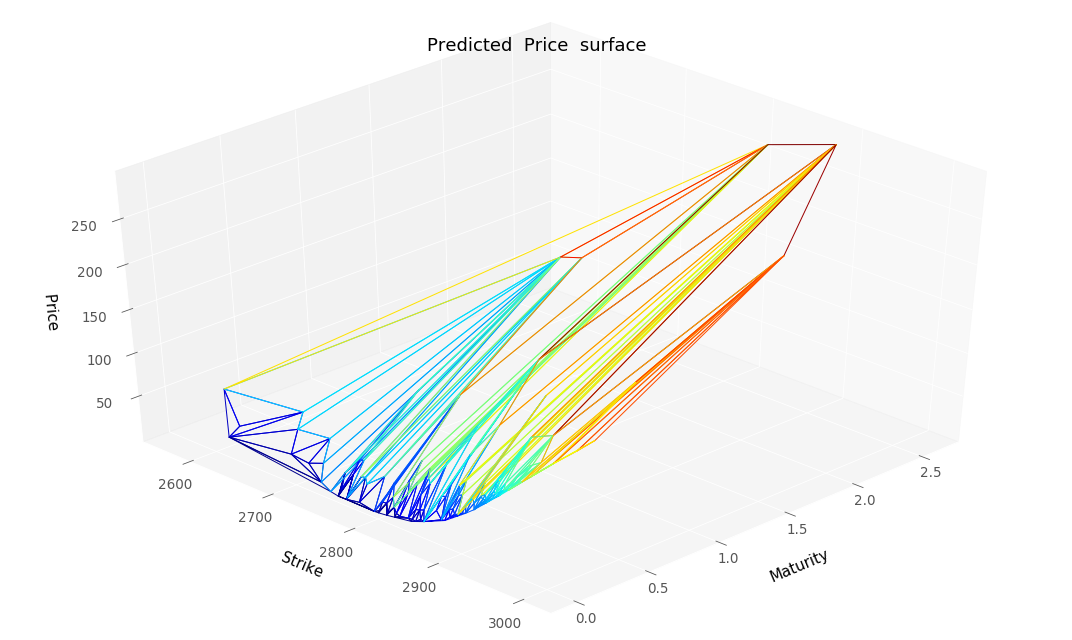

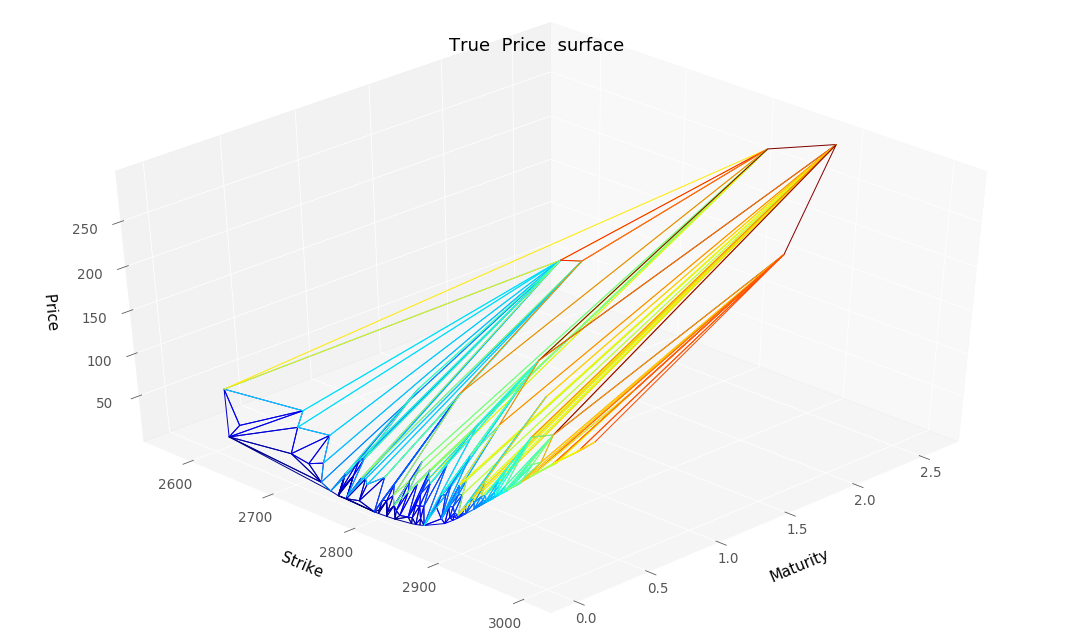

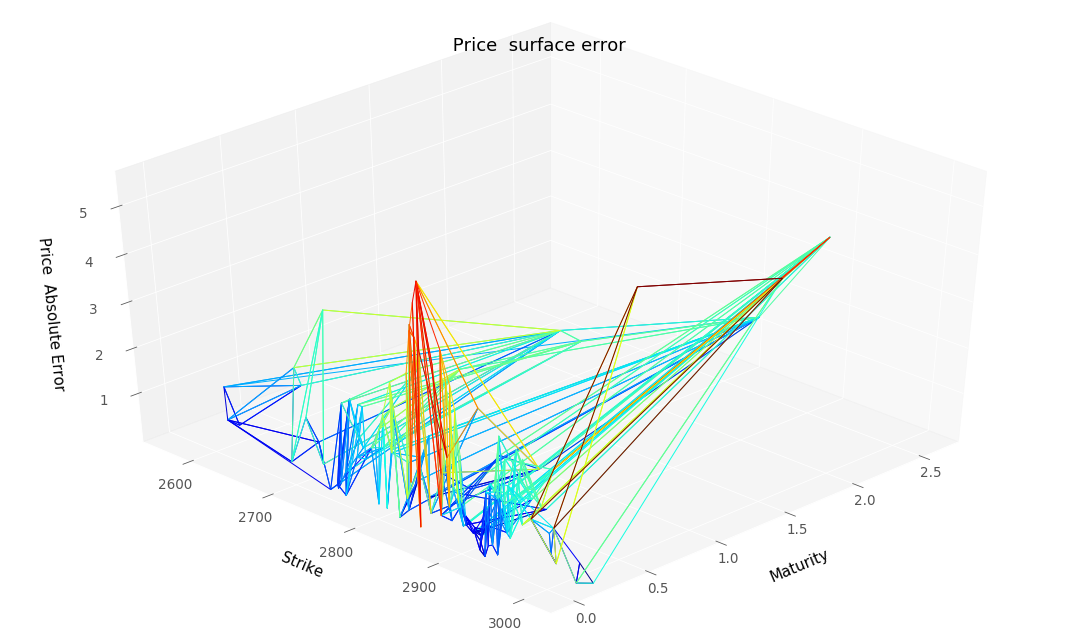

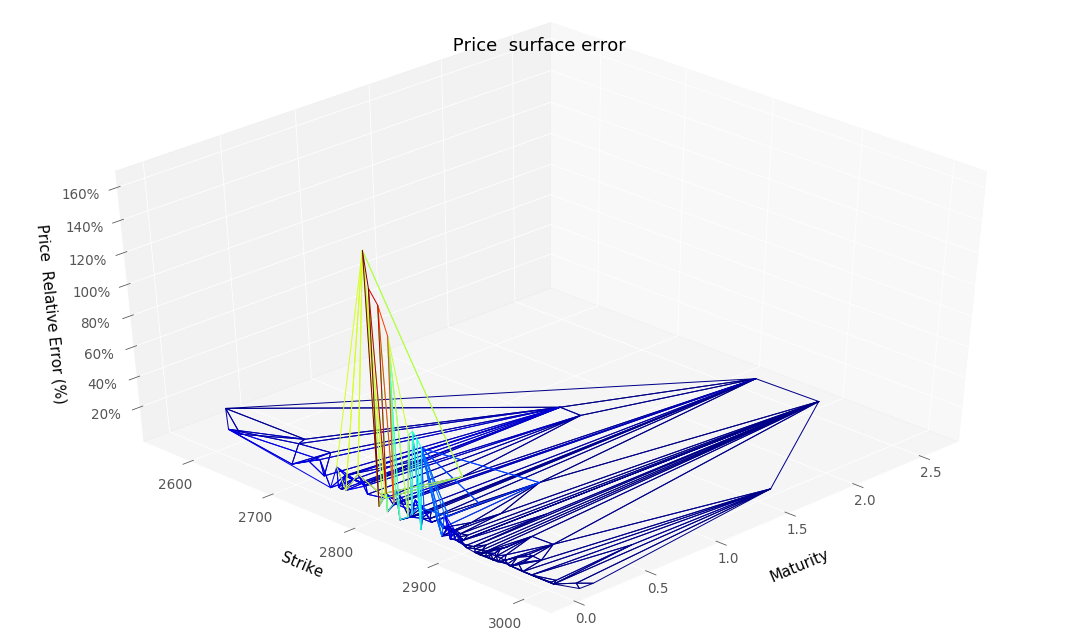

RMSE :  1.8457953164957646
RMSE Relative:  0.2767466327886194


In [32]:
plotTools.predictionDiagnosis(putTestingGP["GP_Put_price"], 
                              dataSetTest['Price'],#ImpVolPutTestingRef, #
                              " Price ", 
                              yMin=2400,
                              yMax=3600, 
                              az = 225,
                              threshold=None)

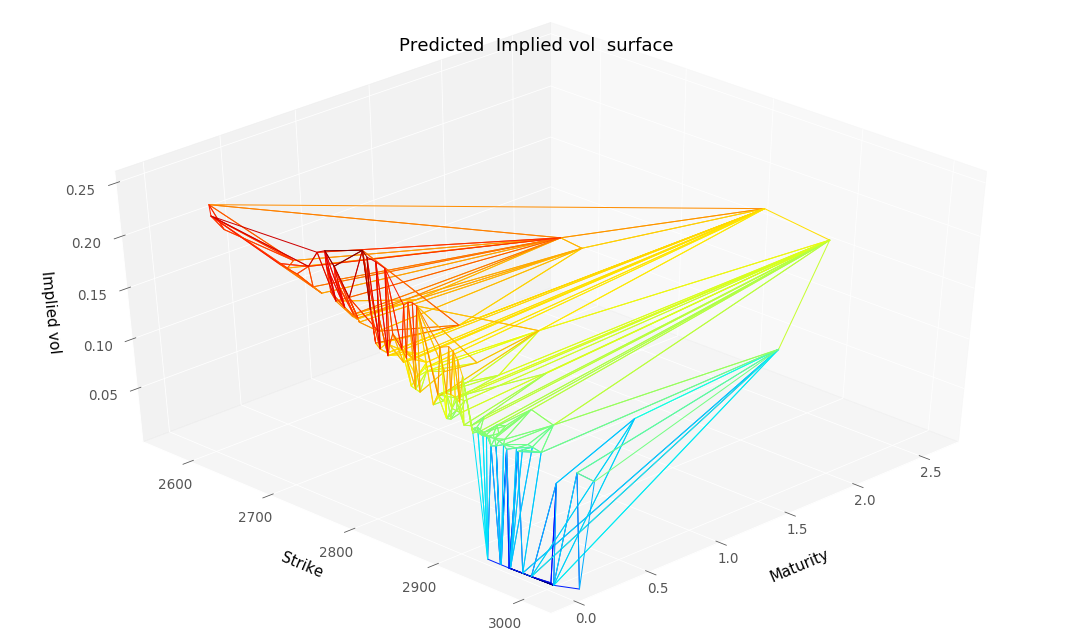

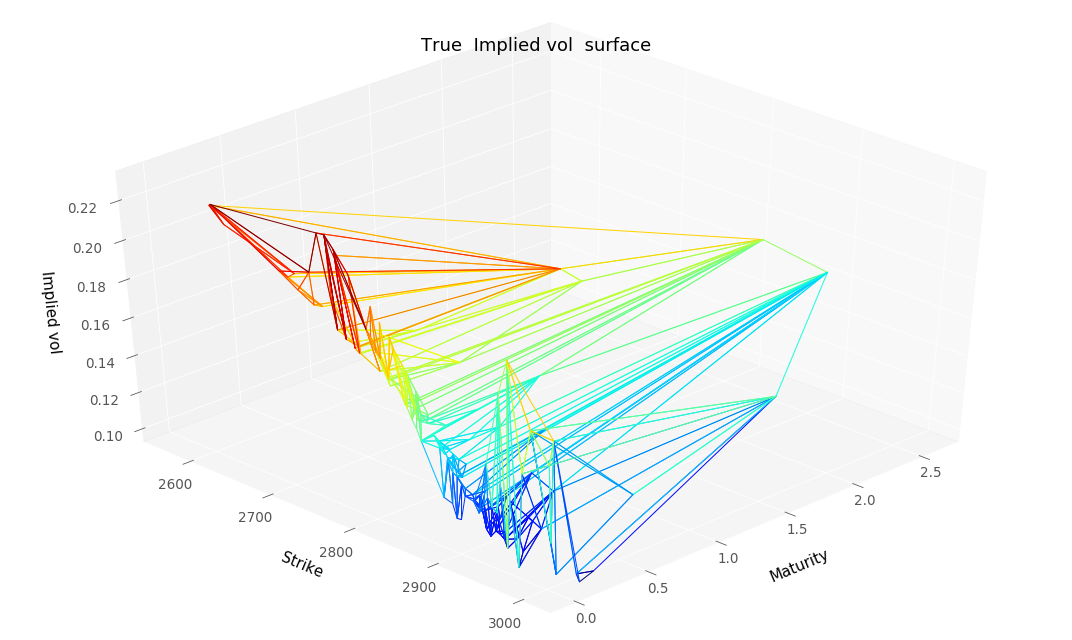

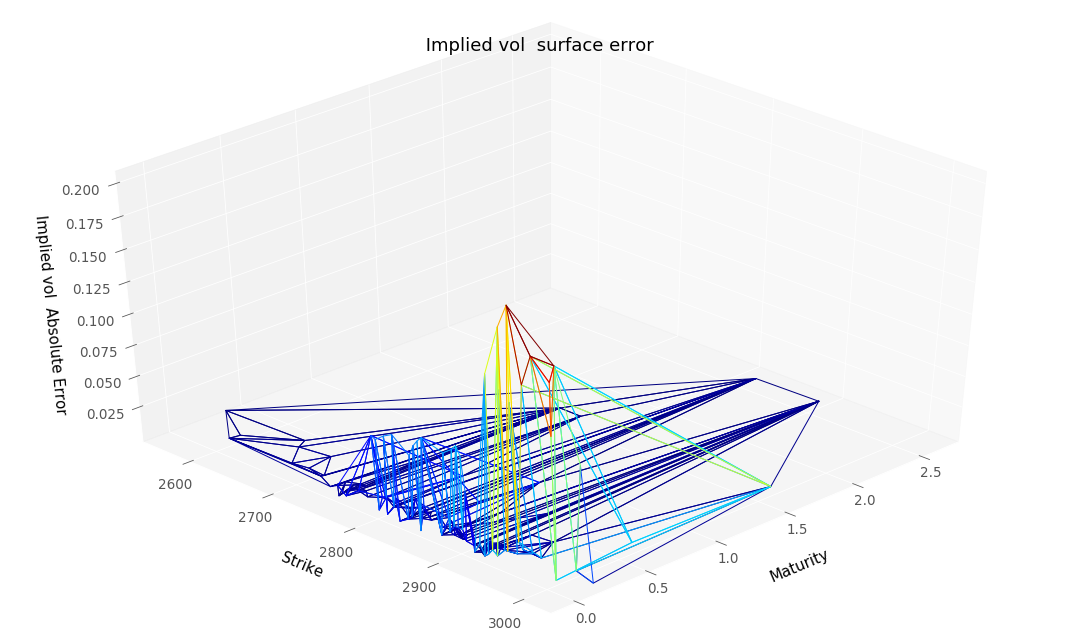

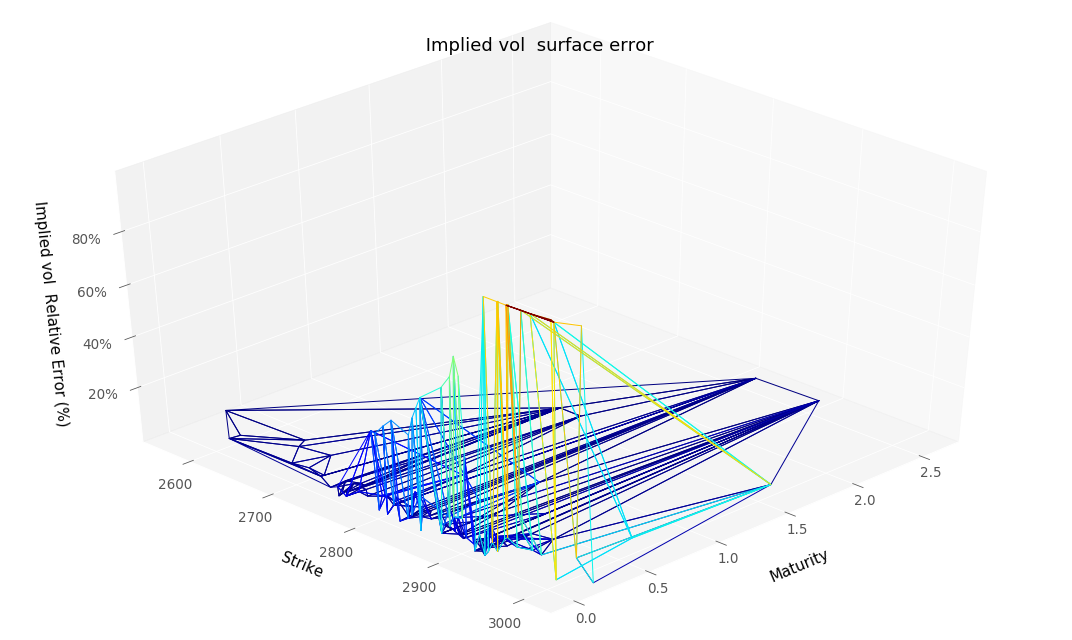

RMSE :  0.0485456689245387
RMSE Relative:  0.32059153408459634


In [33]:
keptPrices = ImpVolPutTesting.dropna().index
plotTools.predictionDiagnosis(plotTools.selectIndex(ImpVolPutTesting, keptPrices), 
                              plotTools.selectIndex(dataSetTest["ImpliedVol"], keptPrices), 
                              " Implied vol ", 
                              yMin=2400,
                              yMax=3600, 
                              az = 225)

In [34]:
pathFolder = "./data/"
fileName = "GP_output_Put_Price_training_set.xlsx"
putTrainingGP = pd.read_excel(pathFolder + fileName,
                              header=0,
                              sheet_name = "Sheet1")
putTrainingGP["Strike"] = np.exp(+ bootstrap.discountIntegral(putTrainingGP["T"])
                                 - bootstrap.dividendIntegral(putTrainingGP["T"])) * putTrainingGP["K"]
putTrainingGP["Maturity"] = putTrainingGP["T"]

putTrainingGP = putTrainingGP.set_index(["Strike","Maturity"], drop=False)

putTrainingGP = pd.DataFrame(putTrainingGP.values, columns = putTrainingGP.columns, index = dataSet.index)
putTrainingGP["StrikeGap"] = dataSet["Strike"] - putTrainingGP["Strike"]
putTrainingGP["Strike"] = dataSet["Strike"]
putTrainingGP["Maturity"] = dataSet["Maturity"]
putTrainingGP["OriginalPrice"] = putTrainingGP["GP_Put_price"] * np.exp(- bootstrap.dividendIntegral(putTrainingGP["T"]))

putTrainingGP.head()

K      T  GP_Modified_Put_price  GP_Put_price  \
Strike Maturity                                                            
2200.0 0.419     2194.553900  0.419              10.000601      9.946592   
2325.0 0.112     2323.142879  0.112               1.786899      1.787044   
2400.0 0.093     2398.742294  0.093               1.244240      1.244625   
2510.0 0.170     2506.841932  0.170               9.440721      9.434888   
2525.0 0.036     2524.212274  0.036               1.141030      1.142168   

                 Strike  Maturity  StrikeGap  OriginalPrice  
Strike Maturity                                              
2200.0 0.419     2200.0     0.419  -0.796497       9.878549  
2325.0 0.112     2325.0     0.112  -2.330992       1.785294  
2400.0 0.093     2400.0     0.093  -0.243060       1.244906  
2510.0 0.170     2510.0     0.170  -1.361214       9.425651  
2525.0 0.036     2525.0     0.036  -0.791540       1.142425

In [35]:
ImpVolPutTraining = BS.vectorizedImpliedVolatilityCalibration(S0, bootstrap, 
                                                              putTrainingGP["T"], 
                                                              putTrainingGP["Strike"], 
                                                              -1 * np.ones_like(putTrainingGP["Strike"]), 
                                                              putTrainingGP["GP_Put_price"], 
                                                              removeNaN= False)
ImpVolPutTraining = pd.Series(ImpVolPutTraining, index = putTrainingGP.set_index(["Strike","Maturity"], drop=False).index).sort_index()

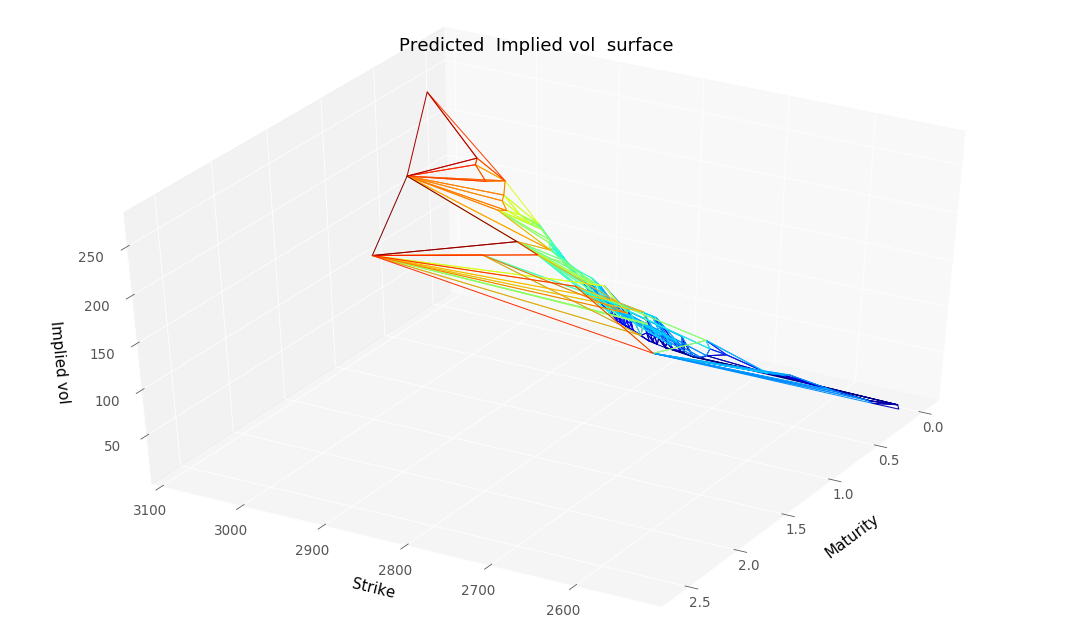

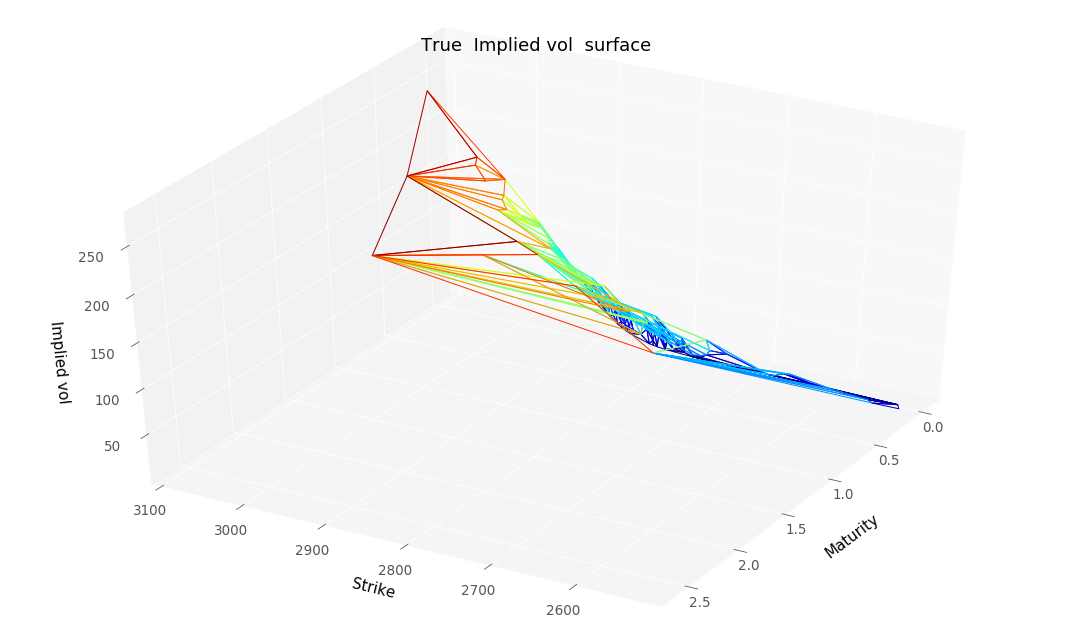

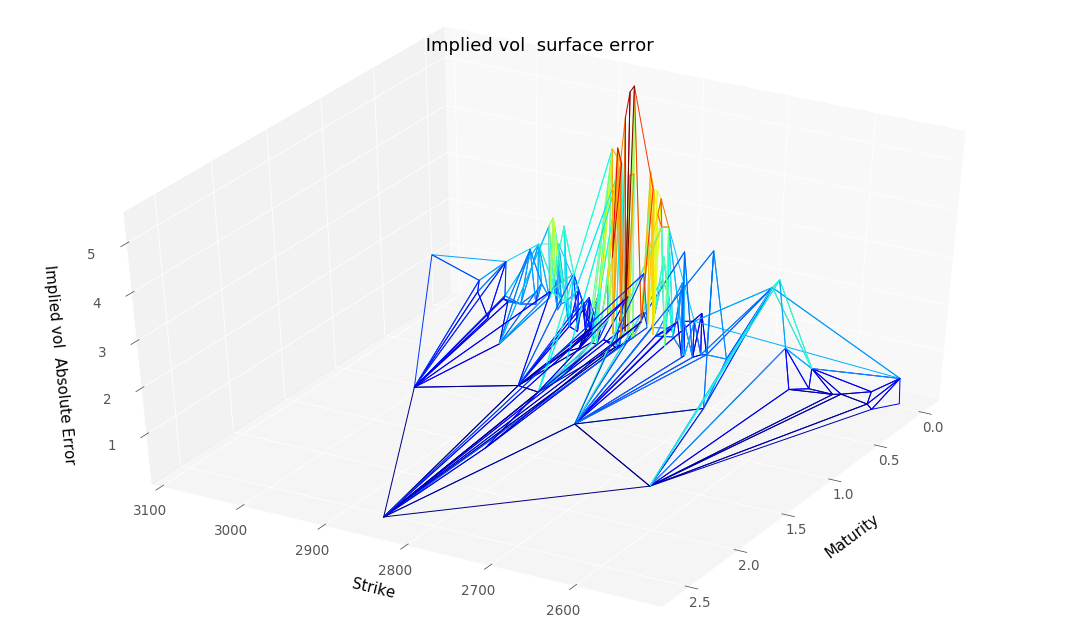

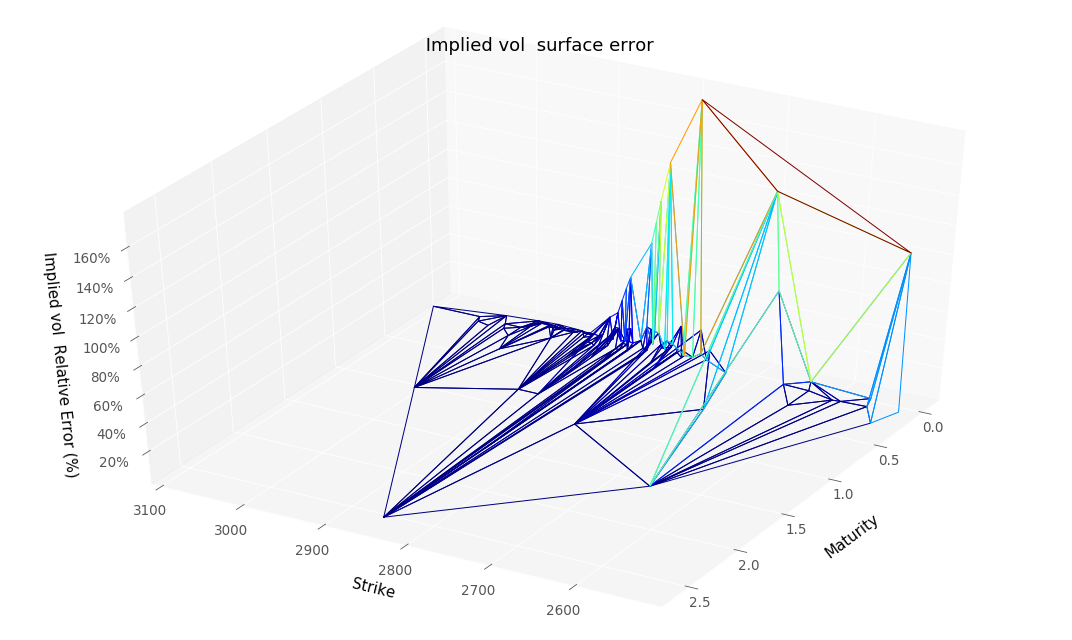

RMSE :  1.663108443188316
RMSE Relative:  0.29335941813084926


In [36]:
plotTools.predictionDiagnosis(putTrainingGP["GP_Put_price"], 
                              dataSet['Price'],
                              " Implied vol ", 
                              yMin=2400,
                              yMax=3600, 
                              az = 30,
                              threshold=None)

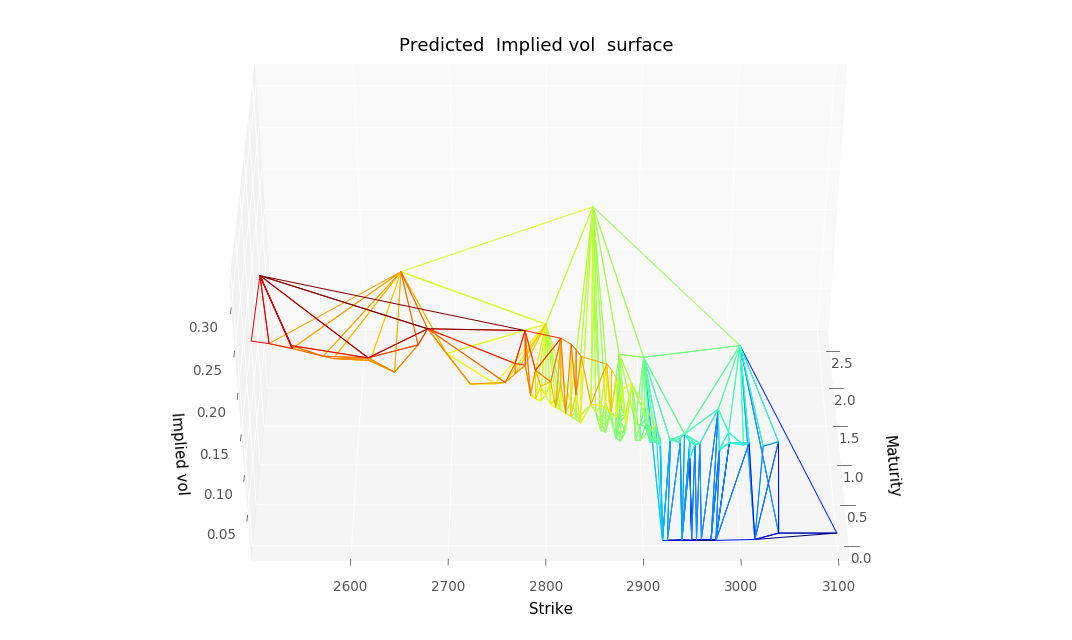

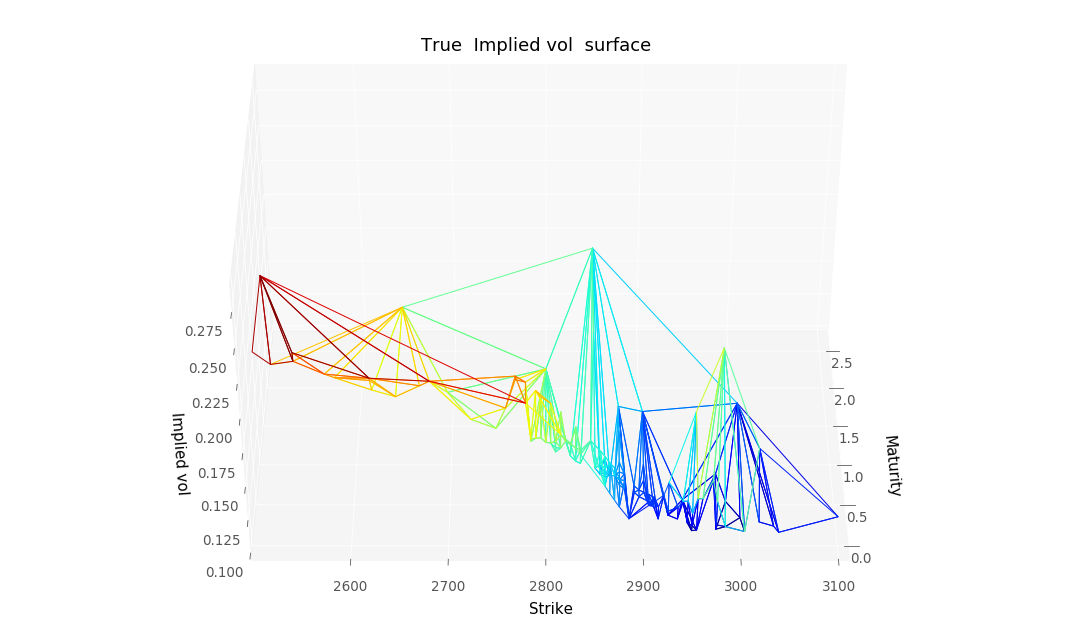

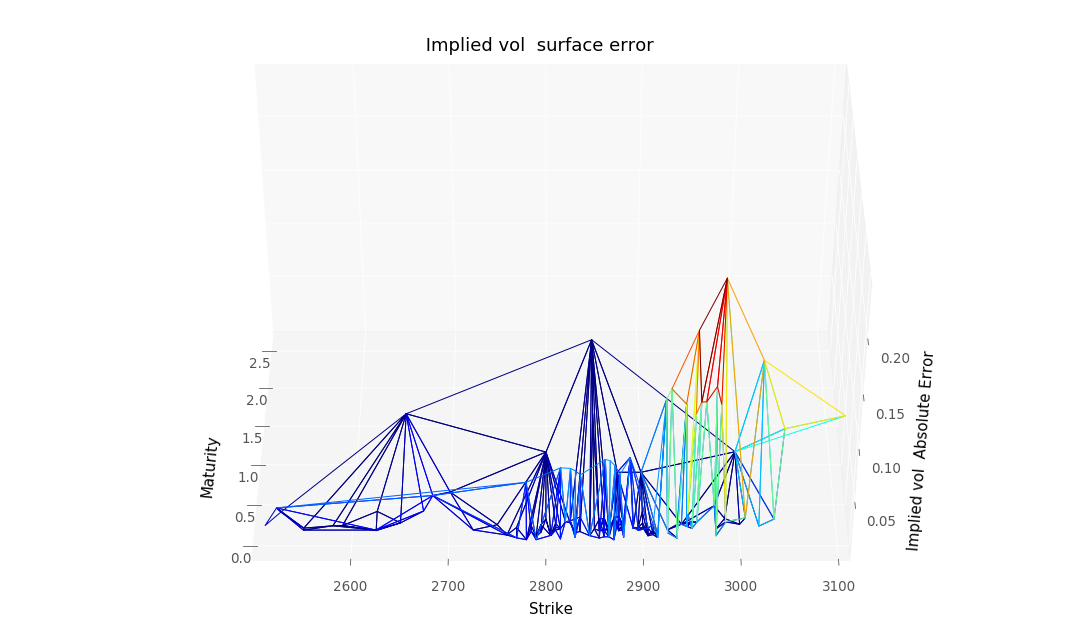

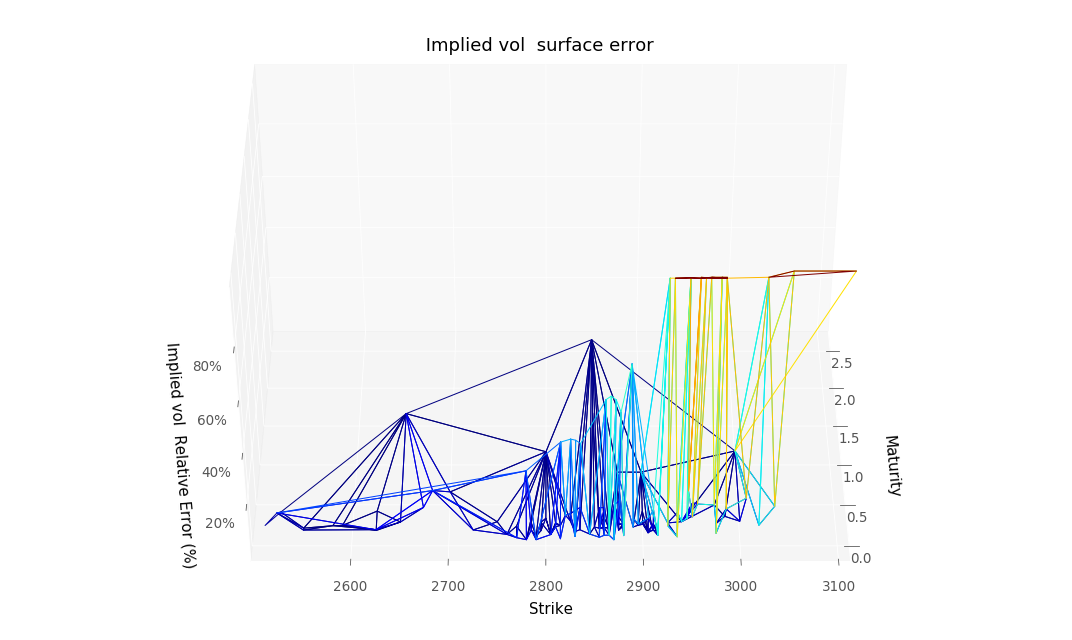

RMSE :  0.05065667104389011
RMSE Relative:  0.3416228686409698


In [37]:
keptPrices = ImpVolPutTraining.dropna().index
plotTools.predictionDiagnosis(plotTools.selectIndex(ImpVolPutTraining, keptPrices), 
                              plotTools.selectIndex(dataSet["ImpliedVol"], keptPrices), 
                              " Implied vol ", 
                              yMin=2400,
                              yMax=3600, 
                              az = 180)

## Load GP local volatility

In [38]:
strikeLow = min(dataSet["Strike"].min(),dataSetTest["Strike"].min()) #dataSet["Strike"].min()
strikeUp = max(dataSet["Strike"].max(),dataSetTest["Strike"].max()) #dataSet["Strike"].max()
strikeGrid = np.linspace(strikeLow, strikeUp, 100)
matLow = min(dataSet["Maturity"].min(),dataSetTest["Maturity"].min()) #dataSet["Maturity"].min()
matUp = max(dataSet["Maturity"].max(),dataSetTest["Maturity"].max()) #dataSetTest["Maturity"].max()
matGrid = np.linspace(matLow, matUp, 100)
volLocaleGrid = np.meshgrid(strikeGrid, matGrid)
volLocaleGridDf = pd.DataFrame(np.vstack((np.ravel(volLocaleGrid[0]), np.ravel(volLocaleGrid[1]))).T, 
                               columns = ["Strike", "Maturity"]).set_index(["Strike","Maturity"],drop=False)
volLocaleGridDf["ChangedStrike"] = bootstrap.changeOfVariable(volLocaleGridDf["Strike"], volLocaleGridDf["Maturity"])[0]
volLocaleGridDf["logMoneyness"] = np.log(volLocaleGridDf["ChangedStrike"] / S0)
volLocaleGridDf["OptionType"] = np.ones_like(volLocaleGridDf["logMoneyness"])

In [39]:
workingFolder = "./data/volLocaleAresky/"
#filename = "local_vol_nx_10_nt_27.xlsx" RMSE :  10.073967351737087
#filename = "local_vol_nx_12_nt_27.xlsx" RMSE :  7.758802111118254
#filename = "local_vol_nx_15_nt_27.xlsx" RMSE :  6.252799135416868
#filename = "local_vol_nx_18_nt_27.xlsx" RMSE :  5.083806059940602
#filename = "local_vol_nx_20_nt_27.xlsx" RMSE :  5.050554384554841
#filename = "local_vol_nx_25_nt_27.xlsx" RMSE :  5.499835852015688
filename = "local_vol_nx_20_nt_27.xlsx"

In [40]:
locVolGP = loadData.loadGPLocVol(workingFolder, filename, bootstrap, S0)

Loading local volatility from :  ./data/volLocaleAresky/local_vol_nx_20_nt_27.xlsx


In [41]:
locVolGP.head()

OptionType  logMoneyness  ChangedStrike    Strike  \
Strike   Maturity                                                      
1769.737 0.150           -1.0     -0.481628    1766.552158  1769.737   
         0.221           -1.0     -0.481716    1766.396569  1769.737   
         0.292           -1.0     -0.481716    1766.396569  1769.737   
         0.363           -1.0     -0.482181    1765.574211  1769.737   
         0.435           -1.0     -0.482667    1764.716939  1769.737   

                   Maturity            K         T  LocalVolatility  
Strike   Maturity                                                    
1769.737 0.150        0.150  1769.736842  0.150000         1.092109  
         0.221        0.221  1769.736842  0.221154         0.715490  
         0.292        0.292  1769.736842  0.292308         0.576198  
         0.363        0.363  1769.736842  0.363462         0.695485  
         0.435        0.435  1769.736842  0.434615         0.725714

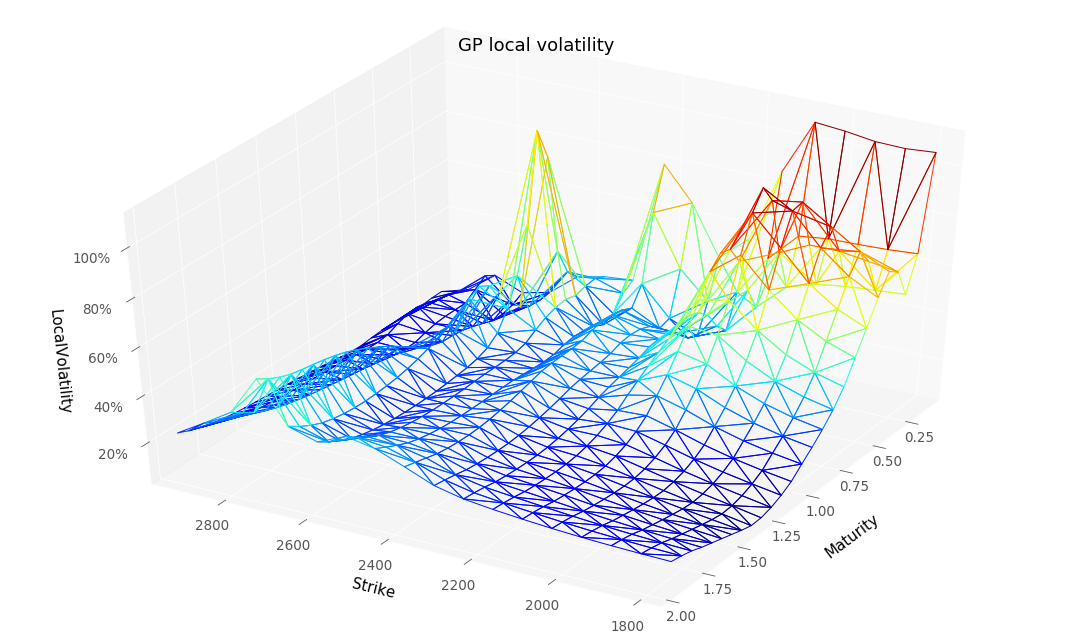

In [42]:
filterLocVol = locVolGP[(locVolGP["Maturity"] <= matUp) & (locVolGP["Maturity"] >= matLow)]
plotTools.plotSerie(filterLocVol["LocalVolatility"],
                    Title = 'GP local volatility',
                    az=30,
                    yMin=KMin,
                    yMax=KMax, 
                    zAsPercent=True)

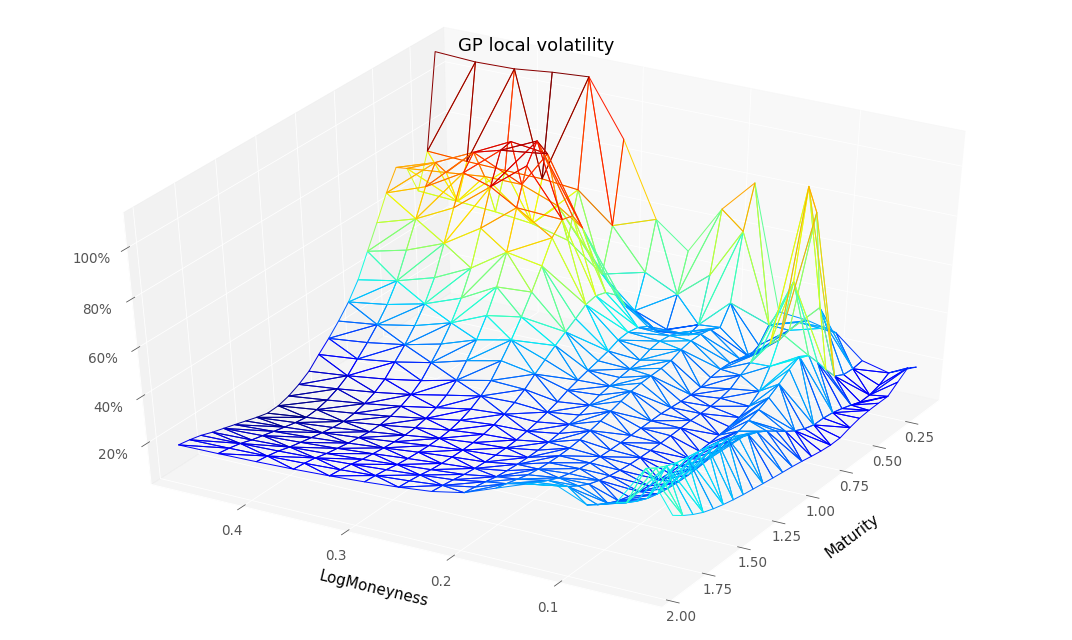

In [43]:
filterLocVol = locVolGP[(locVolGP["Maturity"] <= matUp) & (locVolGP["Maturity"] >= matLow)]
plotTools.plotSerie(plotTools.convertToLogMoneyness(filterLocVol["LocalVolatility"], S0),
                    Title = 'GP local volatility',
                    az=30,
                    yMin=KMin,
                    yMax=KMax, 
                    zAsPercent=True)

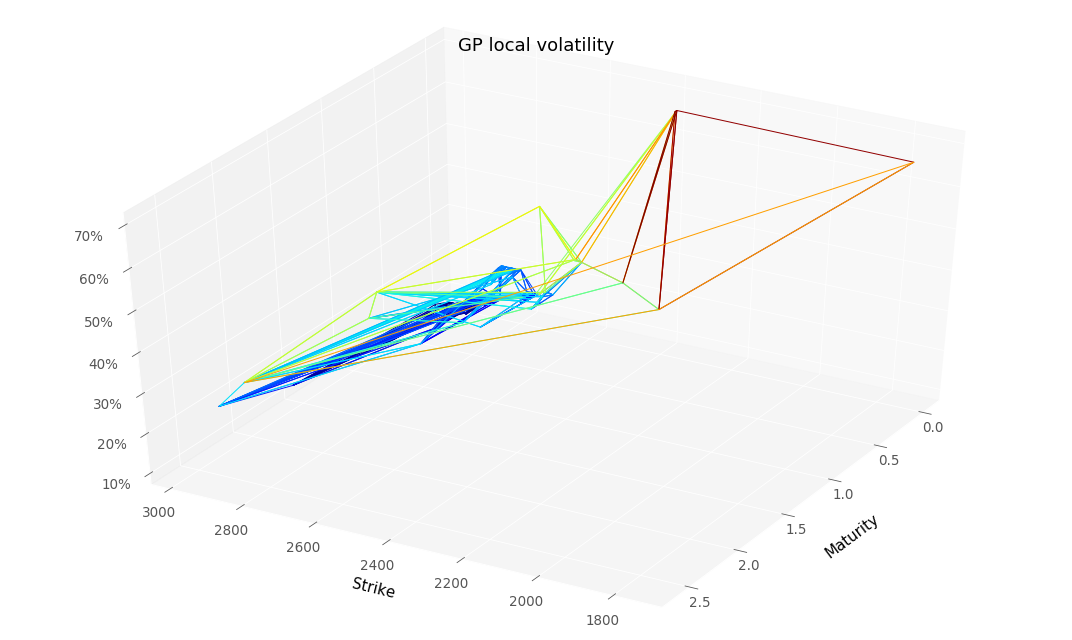

In [44]:
nnGP = lambda x,y : backtest.interpolatedMCLocalVolatility(locVolGP["LocalVolatility"], x, y)
filterLocVol = locVolGP[(locVolGP["Maturity"] <= matUp) & (locVolGP["Maturity"] >= matLow)]

plotTools.plotSerie(nnGP(dataSetTest["Strike"], dataSetTest["Maturity"]),
                    Title = 'GP local volatility',
                    az=30,
                    yMin=KMin,
                    yMax=KMax, 
                    zAsPercent=True)

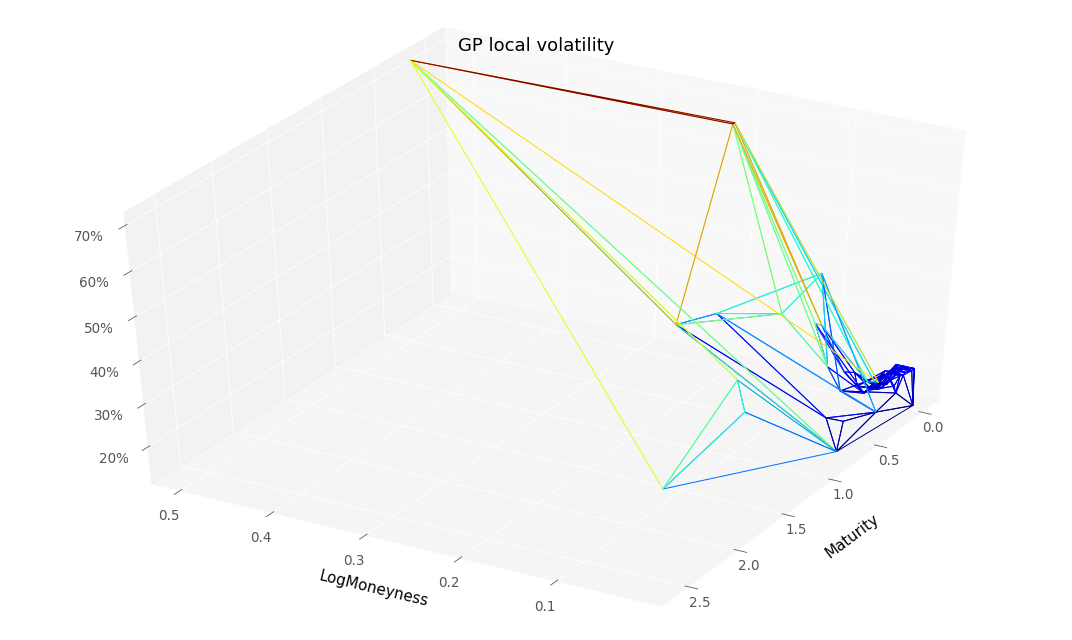

In [45]:
filterLocVol = locVolGP[(locVolGP["Maturity"] <= matUp) & (locVolGP["Maturity"] >= matLow)]

plotTools.plotSerie(plotTools.convertToLogMoneyness(nnGP(dataSetTest["Strike"], dataSetTest["Maturity"]), S0),
                    Title = 'GP local volatility',
                    az=30,
                    yMin=KMin,
                    yMax=KMax, 
                    zAsPercent=True)

/Users/matthewdixon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


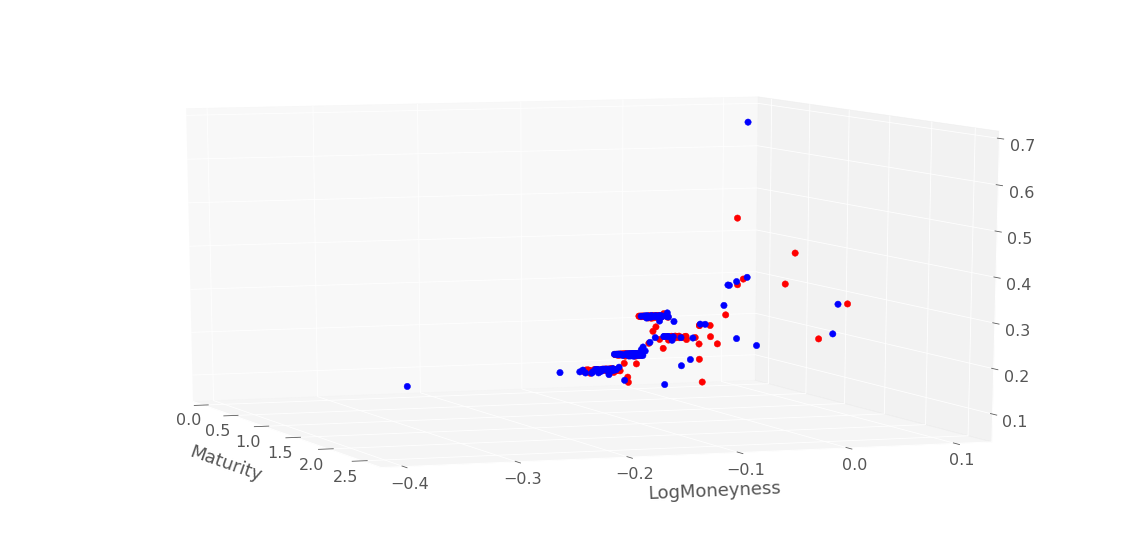

In [46]:
logMin = np.log(KMin/S0), 
logMax = 0.1 #np.log(KMax/S0), 
plotTools.plot2Series(plotTools.convertToLogMoneyness(nnGP(dataSet["Strike"], dataSet["Maturity"]), S0), 
                      plotTools.convertToLogMoneyness(nnGP(dataSetTest["Strike"], dataSetTest["Maturity"]), S0), 
                      yMin=logMin,
                      yMax=logMax,
                      az = 340,
                      Title = 'True Implied Vol Surface')

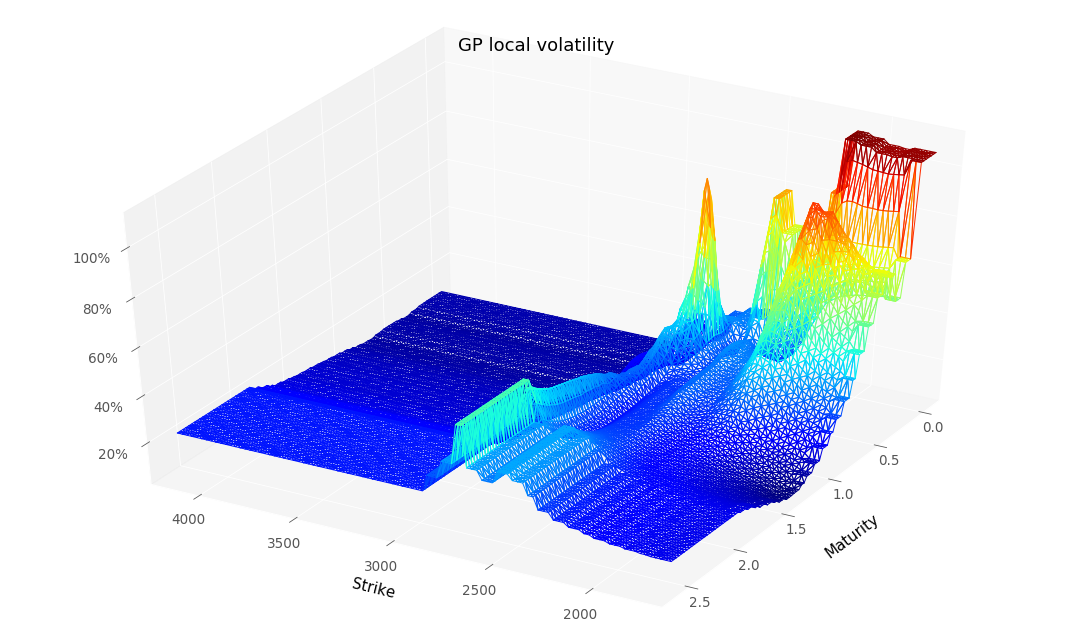

In [47]:
filterLocVol = locVolGP[(locVolGP["Maturity"] <= matUp) & (locVolGP["Maturity"] >= matLow)]
plotTools.plotSerie(nnGP(volLocaleGridDf["Strike"], volLocaleGridDf["Maturity"]),
                    Title = 'GP local volatility',
                    az=30,
                    yMin=KMin,
                    yMax=KMax, 
                    zAsPercent=True)

In [77]:
plotTools.saveDataModel(plotTools.removeDuplicateIndex(putTrainingGP["GP_Put_price"]), 
                        plotTools.removeDuplicateIndex(nnGP(dataSet["Strike"], dataSet["Maturity"])), 
                        plotTools.removeDuplicateIndex(ImpVolPutTraining) , 
                        "./Results/GPTraining") 

In [78]:
plotTools.saveDataModel(plotTools.removeDuplicateIndex(putTestingGP["GP_Put_price"]), 
                        plotTools.removeDuplicateIndex(nnGP(dataSetTest["Strike"], dataSetTest["Maturity"])), 
                        plotTools.removeDuplicateIndex(ImpVolPutTesting) , 
                        "./Results/GPTesting") 

#### GP Local Volatility Backtests

During Monte Carlo backtest, each option in testing set is priced with an underlying which is diffused with the following SDE : 
$$ dS_t = \left( r_t - q_t - \frac{\sigma_{NN}^2(t, S_t)}{2} \right) dt + \sigma_{NN}(t, S_t) dW_t$$
with $\sigma_{NN}$ the neural local volatility function.

Due to computation time issue we avoid to make millions of call to neural network and we interpolate linearly neural local volatility obtained on one the two possible grid :
- the testing grid i.e. nodes $(T,K)$ of the testing set.
- an artificial grid of 10000 points to check local volatility is correctly interpolated/extrapolated. That grid is the smallest rectangle containing the minimum and maximum maturities and the minimum and maximum strikes of our dataset (union of testing and training set).

During PDE backtest, we used a crank-nicholson scheme to revaluate each option in our testing set.
Time step corresponds to one day and space grid has 100 points. 

In [75]:
nbTimeStep = 100
nbPaths = 100000

In [76]:
importlib.reload(backtest)

<module 'backtest' from './code/backtest.py'>

In [77]:
nnGP = lambda x,y : backtest.interpolatedMCLocalVolatility(locVolGP["LocalVolatility"], x, y)

In [78]:
strikeLow = min(dataSet["Strike"].min(),dataSetTest["Strike"].min()) #dataSet["Strike"].min()
strikeUp = max(dataSet["Strike"].max(),dataSetTest["Strike"].max()) #dataSet["Strike"].max()
strikeGrid = np.linspace(strikeLow, strikeUp, 100)
matLow = min(dataSet["Maturity"].min(),dataSetTest["Maturity"].min()) #dataSet["Maturity"].min()
matUp = max(dataSet["Maturity"].max(),dataSetTest["Maturity"].max()) #dataSetTest["Maturity"].max()
matGrid = np.linspace(matLow, matUp, 100)
volLocaleGrid = np.meshgrid(strikeGrid, matGrid)
volLocaleGridDf = pd.DataFrame(np.vstack((np.ravel(volLocaleGrid[0]), np.ravel(volLocaleGrid[1]))).T, 
                               columns = ["Strike", "Maturity"]).set_index(["Strike","Maturity"],drop=False)
volLocaleGridDf["ChangedStrike"] = bootstrap.changeOfVariable(volLocaleGridDf["Strike"], volLocaleGridDf["Maturity"])[0]
volLocaleGridDf["logMoneyness"] = np.log(volLocaleGridDf["ChangedStrike"] / S0)
volLocaleGridDf["OptionType"] = np.ones_like(volLocaleGridDf["logMoneyness"])

In [79]:
volLocaleGridDf.head()

Strike  Maturity  ChangedStrike  logMoneyness  \
Strike      Maturity                                                       
1700.000000 0.005     1700.000000     0.005    1698.937070     -0.520654   
1725.252525 0.005     1725.252525     0.005    1724.173806     -0.505909   
1750.505051 0.005     1750.505051     0.005    1749.410542     -0.491378   
1775.757576 0.005     1775.757576     0.005    1774.647278     -0.477056   
1801.010101 0.005     1801.010101     0.005    1799.884015     -0.462935   

                      OptionType  
Strike      Maturity              
1700.000000 0.005            1.0  
1725.252525 0.005            1.0  
1750.505051 0.005            1.0  
1775.757576 0.005            1.0  
1801.010101 0.005            1.0

In [86]:
mcResGPTest = backtest.MonteCarloPricerVectorized(S0,
                                                  dataSetTest,
                                                  bootstrap,
                                                  nbPaths,
                                                  nbTimeStep,
                                                  nnGP)
mcResGPTest.head()

Price    stdPrice
Strike Maturity                       
1700.0 0.246      0.833726   18.403973
2300.0 0.419     13.380419   92.245855
2350.0 0.093      0.384814   10.245258
       0.112      0.994517   18.210803
2400.0 0.419     20.646870  110.514794

In [87]:
mcResGPTest.to_csv(workingFolder + "mcResGPTest.csv")

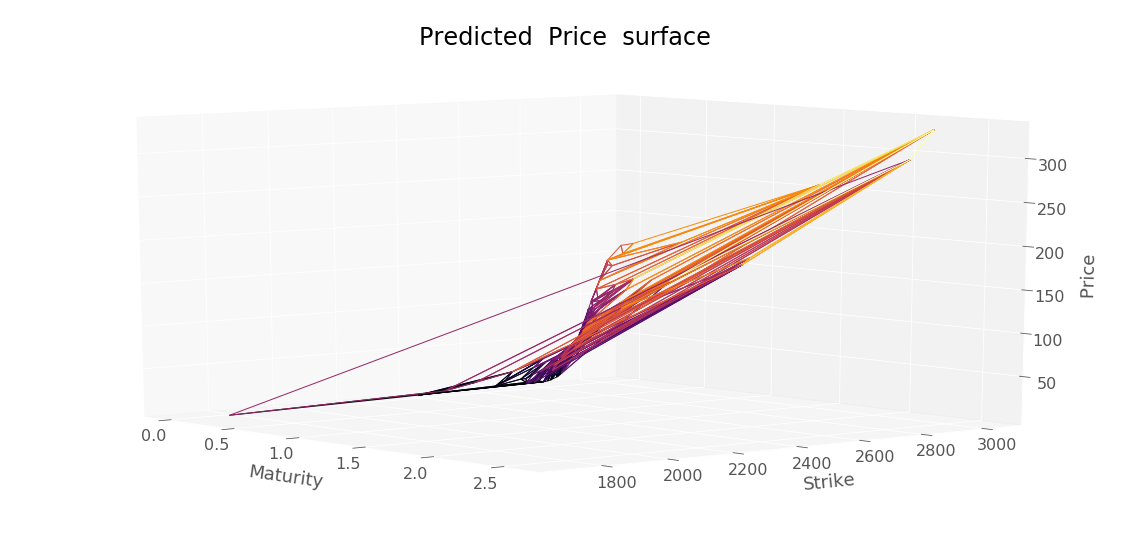

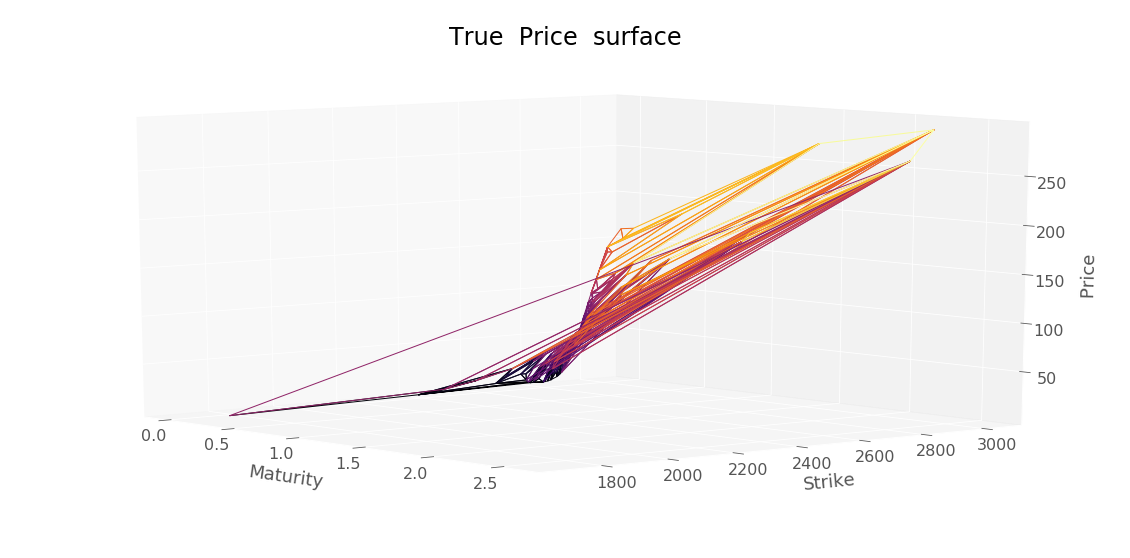

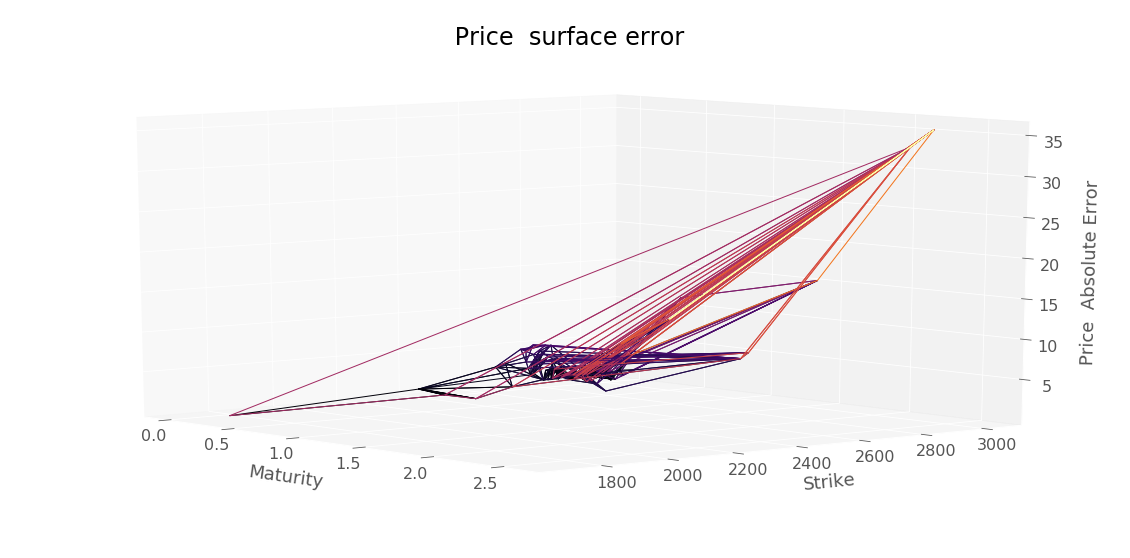

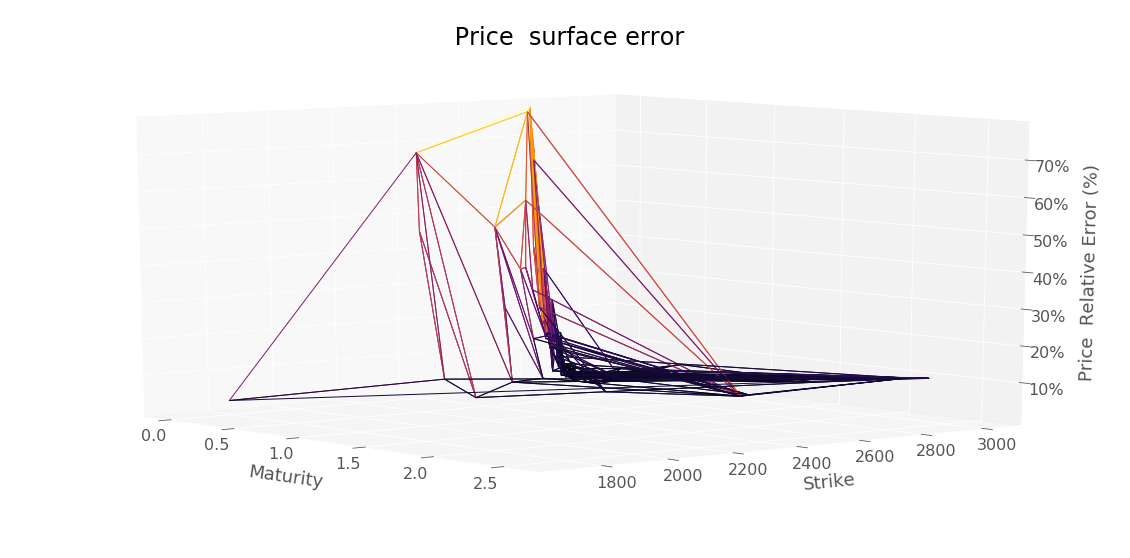

RMSE :  4.997789723328307


In [88]:
plotTools.predictionDiagnosis(mcResGPTest["Price"], 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=KMin,
                              yMax=KMax)

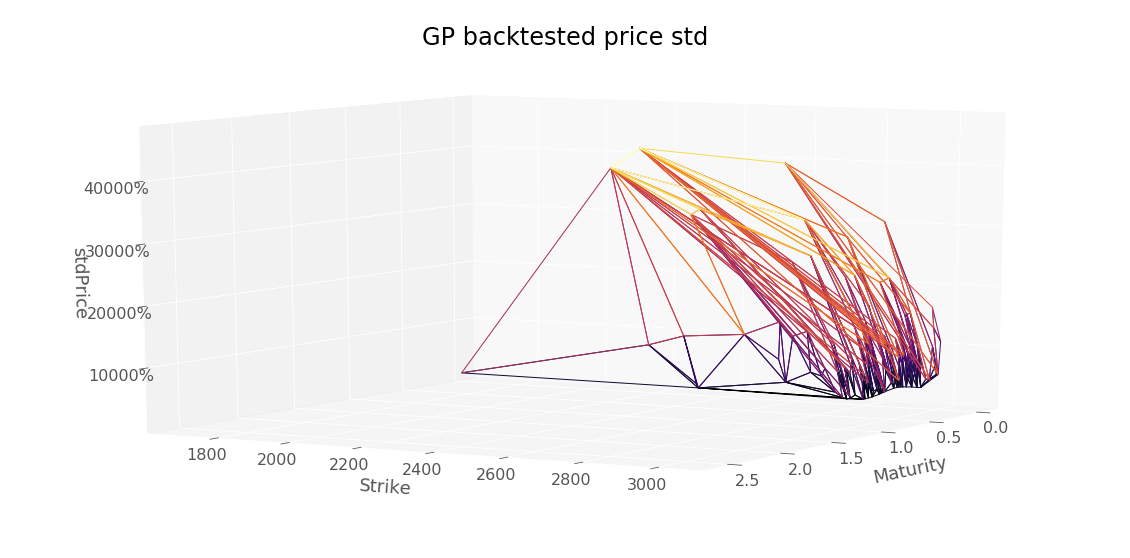

In [89]:
plotTools.plotSerie(mcResGPTest["stdPrice"],
                    Title = 'GP backtested price std',
                    az=30,
                    yMin=KMin,
                    yMax=KMax, 
                    zAsPercent=True)

In [90]:
testingDataSetGP = dataSetConstruction.interpolatedLocalVolatility(locVolGP, 
                                                                   dataSetTest["Price"])

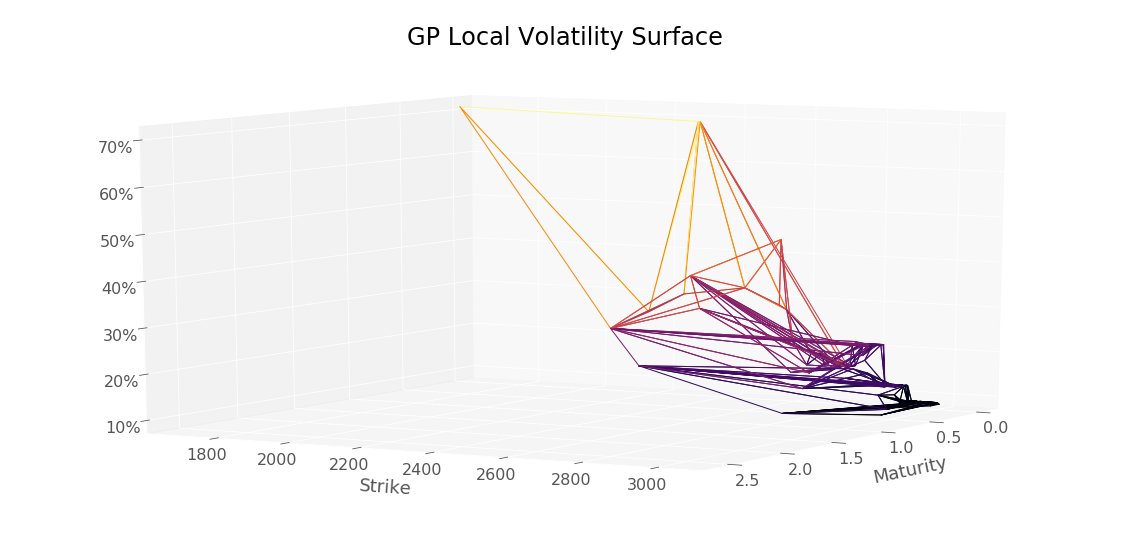

In [91]:
plotTools.plotSerie(testingDataSetGP,
                    Title = 'GP Local Volatility Surface',
                    az=30,
                    yMin=KMin,
                    yMax=KMax, 
                    zAsPercent=True)

In [92]:
pdeResSigmaGPTest = backtest.PDEPricerVectorized(dataSetTest, S0, nnGP, bootstrap)
pdeResSigmaGPTest.head()

Strike  Maturity
1700.0  0.246        0.594552
2300.0  0.419       10.923903
2350.0  0.093        0.756563
        0.112        1.130061
2400.0  0.419       19.264846
dtype: float64

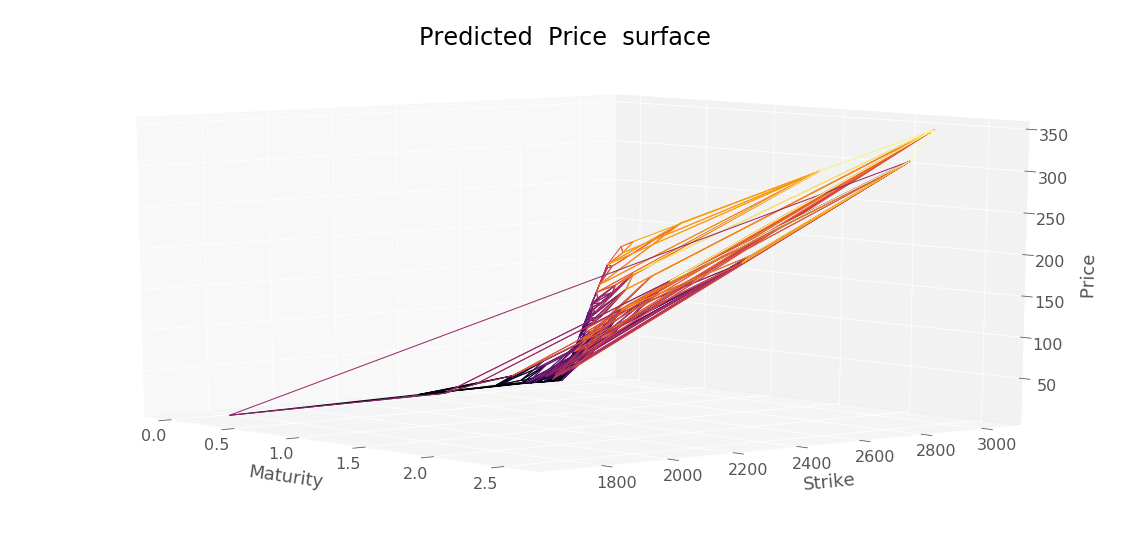

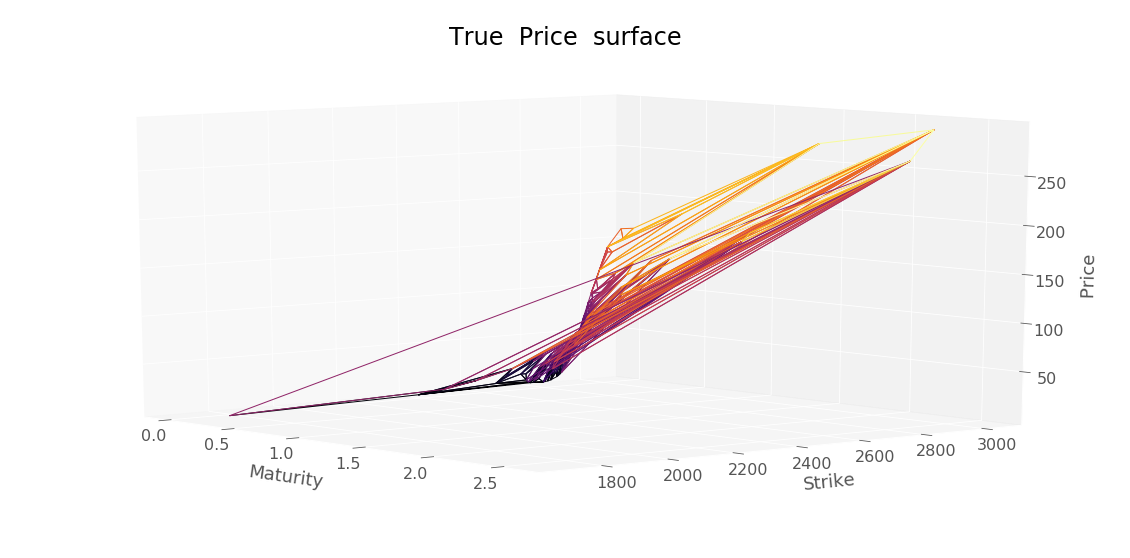

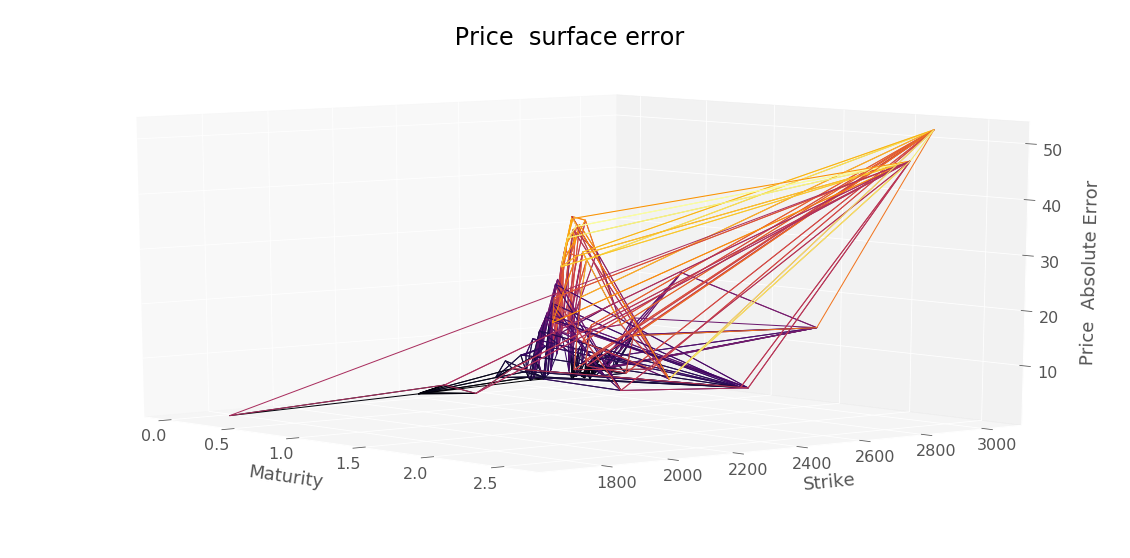

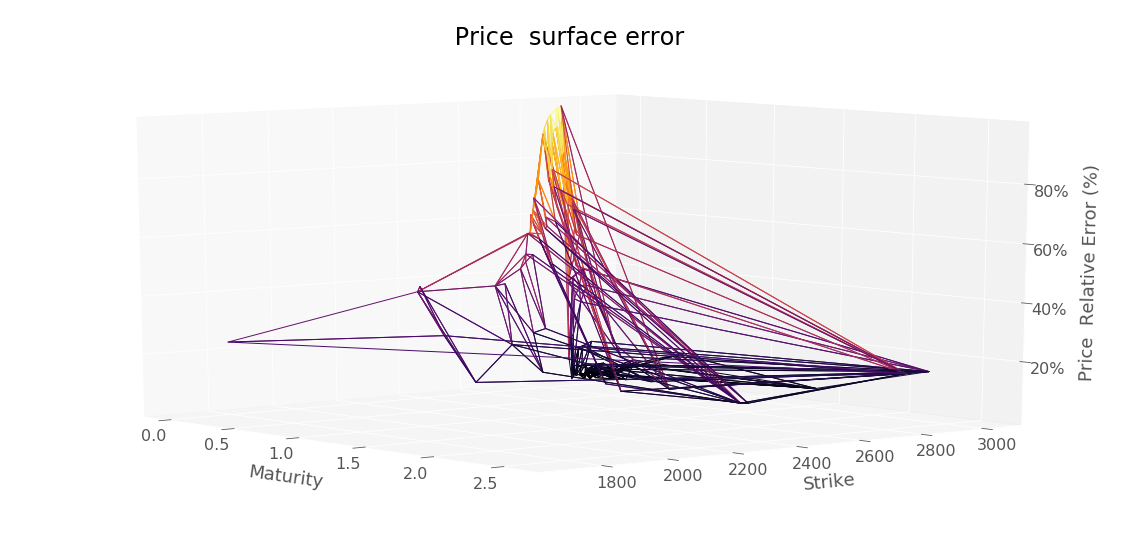

RMSE :  13.418144696130524


In [93]:
plotTools.predictionDiagnosis(pdeResSigmaGPTest, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=KMin,
                              yMax=KMax)

In [95]:
pdeResSigmaGPTest.to_csv(workingFolder + "pdeResSigmaGPTest.csv")

/home/chataigner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
